### **TUGAS AKHIR**
Pada penelitian ini akan dilakukan pencarian pengaruh penambahan regularisasi terhadap akurasi deep learning dalam deteksi penyakit diabetes retinopati.

Link Dataset :
[Diabetes Retinopati](https://www.kaggle.com/competitions/diabetic-retinopathy-detection)


---
Arsitektur yang digunakan :
1.   VGG16
2.   ResNet-50



Regularisasi yang dilakukan :
1. L1 Regularization
2. L2 Regularization
3. Elastic Net Regularization
4. Dropout
5. Early Stopping
6. Data Augmentasi
7. Batch Normalization

### Data Preparation - Organize the Data

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os
import shutil
import random
import cv2
from keras.preprocessing.image import ImageDataGenerator

from scipy.stats import f_oneway
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [36]:
len(os.listdir('/AiDiTech/Penelitian Kak Guntur/train/train'))

35126

In [77]:
data = pd.read_csv('trainLabels.csv')
data.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [78]:
# make a dataframe
df = pd.DataFrame()

df['filename'] = data['image'].apply(lambda x : x + '.jpeg')
df['path'] = data['image'].apply(lambda x : 'train/' + x + '.jpeg')
df['patient_id'] = data['image'].apply(lambda x : x.split('_')[0])
df['eye_side'] = data['image'].apply(lambda x : x.split('_')[1])
df['level'] = data['level']
df

,filename,path,patient_id,eye_side,level
0,10_left.jpeg,train/10_left.jpeg,10,left,0
1,10_right.jpeg,train/10_right.jpeg,10,right,0
2,13_left.jpeg,train/13_left.jpeg,13,left,0
3,13_right.jpeg,train/13_right.jpeg,13,right,0
4,15_left.jpeg,train/15_left.jpeg,15,left,1
...,...,...,...,...,...
35121,44347_right.jpeg,train/44347_right.jpeg,44347,right,0
35122,44348_left.jpeg,train/44348_left.jpeg,44348,left,0
35123,44348_right.jpeg,train/44348_right.jpeg,44348,right,0
35124,44349_left.jpeg,train/44349_left.jpeg,44349,left,0


In [39]:
# untuk mengetahui persebaran data apakah sudah seimbang atau belum
df['level'].value_counts().sort_values(ascending=False)

0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

In [40]:
num_classes = len(np.unique(df['level']))
num_classes

5

<BarContainer object of 5 artists>

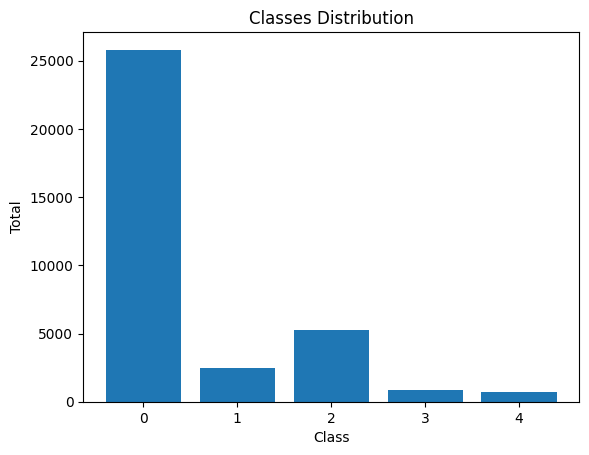

In [16]:
# visualize classes distribution
class_dist = [len(df.loc[df['level'] == x]) for x in range(num_classes)]
plt.title('Classes Distribution')
plt.xlabel('Class')
plt.ylabel('Total')
plt.bar(np.unique(df['level']), class_dist)

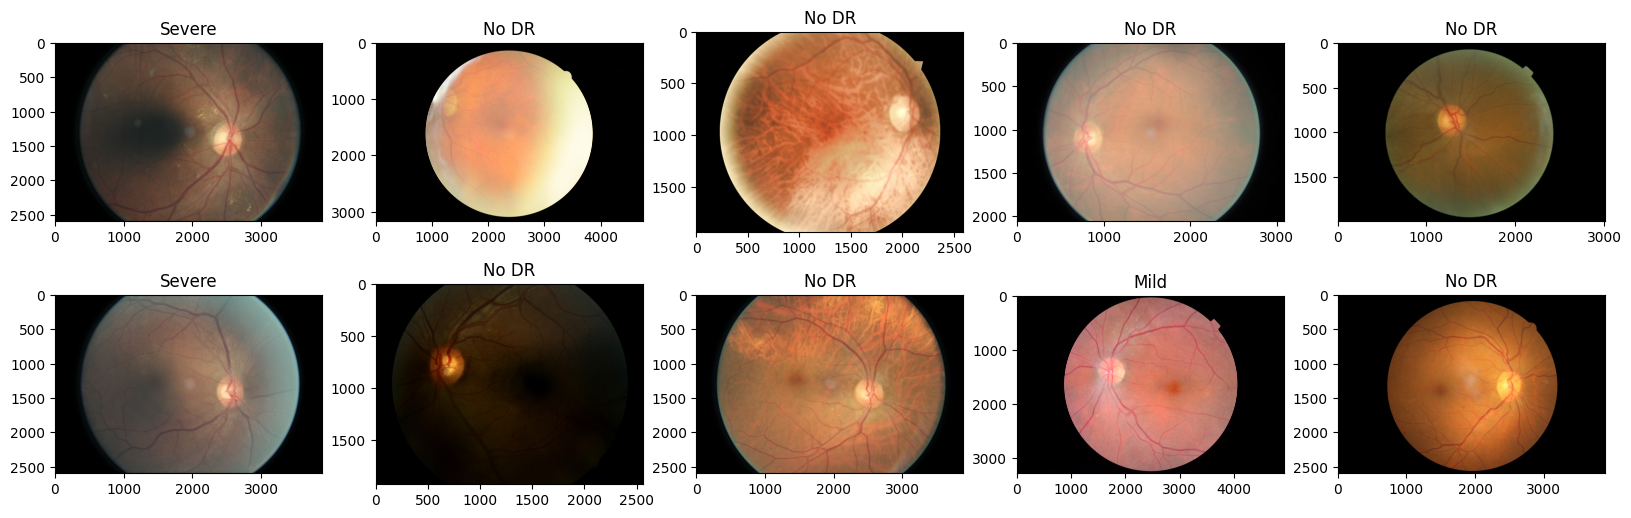

In [20]:
#visualize
img_path = '/AiDiTech/Penelitian Kak Guntur/train/'
labels = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
plt.figure(figsize=(20,6))
for i in range (10) :
  ax = plt.subplot(2,5,i+1)
  rand = random.choice(range(len(df)))
  img = plt.imread(img_path+df['path'][rand])
  plt.imshow(img, cmap='gray')
  plt.title(labels[df['level'][rand]])

#### Split the Data (ALREADY RUNNED)

Train : 80% of the data\
Test : 20% of the data\
Validation : 25% of the train data

In [ ]:
from sklearn.model_selection import train_test_split

x = df.drop('level', axis=1) # axis 1 = column
y = df['level']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Further split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Print the shapes of the resulting sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

#### Insert Image Into Directory (ALREADY RUNNED)
Setelah data berhasil di split, maka dilakukan pembuatan directory baru untuk data train, validation, dan tes

In [14]:
# def makedirs (mode) :
#   # Set up the directory structure
#   categories = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
#   data_categories = ['train', 'val', 'test']
#   target_directory = 'data'

#   # Make a directories
#   for data in data_categories :
#     new_dir = os.path.join(target_directory, data)
#     os.makedirs(new_dir, exist_ok=True)

#     for category in categories :
#       category_dir = os.path.join(new_dir, category)
#       os.makedirs(category_dir, exist_ok=True)


#   # Copy or move the selected images to the target directory
#   if mode=='train' :
#     for image_file in X_train['path']:
#       lvl = y_train[X_train['path']==image_file]

#       for i in range (5) :
#         if int(lvl) == i :
#           shutil.copy2(image_file, target_directory + '/' + data_categories[0] + '/' +categories[i])

#   elif mode=='valid' :
#     for image_file in X_val['path']:
#       lvl = y_val[X_val['path']==image_file]

#       for i in range (5) :
#         if int(lvl) == i :
#           shutil.copy2(image_file, target_directory + '/' + data_categories[1] + '/' + categories[i])

#   elif mode=='test' :
#     for image_file in X_test['path']:
#       lvl = y_test[X_test['path']==image_file]

#       for i in range (5) :
#         if int(lvl) == i :
#           shutil.copy2(image_file, target_directory + '/' + data_categories[2] + '/' + categories[i])

In [15]:
# makedirs('train')
# makedirs('valid')
# makedirs('test')

In [21]:
path = 'data'
test, train, val = 0, 0, 0

for i in os.listdir(path) :
  newdir = os.path.join(path, i)
  for j in os.listdir(newdir) :
    newdirr = os.path.join(newdir, j)
    if i == 'test' :
      test+=len(os.listdir(newdirr))
    elif i == 'train' :
      train+=len(os.listdir(newdirr))
    else :
      val+=len(os.listdir(newdirr))

print("Jumlah data train : ", train)
print("Jumlah data validation : ", val)
print("Jumlah data test : ", test)

Jumlah data train :  21075
Jumlah data validation :  7025
Jumlah data test :  7026


Text(0, 0.5, 'Total')

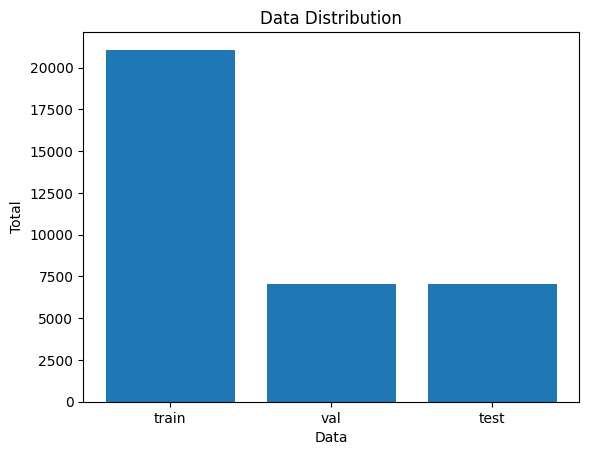

In [22]:
plt.bar(['train', 'val','test'], [train, val, test])
plt.title('Data Distribution')
plt.xlabel('Data')
plt.ylabel('Total')

#### Image Augmentation
Methods :
1. Rotating ✅
2. Zoom ✅
3. Flipping (Vertically & Horizontally) ✅
4. Shifting (Width & Height Shift) ✅
5. Shear ✅
6. Color Jittering (Brightness & Contrast) ✅
7. Noise Adding ✅

In [17]:
# ALREADY RUNNED

# categories = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
# data_categories = ['train']
# target_directory = 'augmented_data'

# os.makedirs(target_directory)

# for data in data_categories :
#   new_dir = os.path.join(target_directory, data)
#   os.makedirs(new_dir, exist_ok=True)

#   for category in categories :
#     category_dir = os.path.join(new_dir, category)
#     os.makedirs(category_dir, exist_ok=True)

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, array_to_img
from keras.utils.image_utils import load_img

In [5]:
input_dir = 'data/train'
output_dir = 'augmented_data/train'

In [4]:
def add_gaussian_noise(image, mean, std):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8) # utk membatasi array agar memiliki range 0 - 255
    return noisy_image

In [10]:
folder = os.listdir(input_dir)

for cat in folder :
  cat_dir = os.path.join(input_dir, cat)

  for filename in os.listdir(cat_dir):
    image = load_img(os.path.join(cat_dir, filename))
    arr_img = img_to_array(image)

    # Expand dimensions to match the expected shape for augmentation
    x = arr_img.reshape((1,) + arr_img.shape)

    # Generator
    # rotate_gen = ImageDataGenerator(rotation_range=90, fill_mode='constant') # random rotated between 0-90
    # shear_gen = ImageDataGenerator(shear_range=45) # random sheared by maximum 45 degrees
    # shift_width_gen = ImageDataGenerator(width_shift_range=0.25, fill_mode='constant') # random shifted by a maximum of 20% of their total width / height
    # shift_height_gen = ImageDataGenerator(height_shift_range=0.25)
    bright_up_gen = ImageDataGenerator(brightness_range=[1.2, 1.8]) # random change the brightness with min value = 120% and max value = 180% than the og img
    bright_down_gen = ImageDataGenerator(brightness_range=[0.2, 0.5])
    contrast_gen = ImageDataGenerator(channel_shift_range=100)
    # zoom_gen = ImageDataGenerator(zoom_range=0.7, fill_mode='constant') # zoom 80% from the og img

    # Generate augmented images
    # rotated_images = rotate_gen.flow(x, batch_size=1,
    #                                     save_to_dir=os.path.join(output_dir, cat),
    #                                     save_prefix='aug_rotate_' + filename.split('.jpeg')[0],
    #                                     save_format='jpeg')
    # sheared_images = shear_gen.flow(x, batch_size=1,
    #                                     save_to_dir=os.path.join(output_dir, cat),
    #                                     save_prefix='aug_shear_' + filename.split('.jpeg')[0],
    #                                     save_format='jpeg')
    # shifted_width_images = shift_width_gen.flow(x, batch_size=1,
    #                                             save_to_dir=os.path.join(output_dir, cat),
    #                                             save_prefix='aug_shift-height_' + filename.split('.jpeg')[0],
    #                                             save_format='jpeg')
    # shifted_height_images = shift_height_gen.flow(x, batch_size=1,
    #                                               save_to_dir=os.path.join(output_dir, cat),
    #                                               save_prefix='aug_shift-width_' + filename.split('.jpeg')[0],
    #                                               save_format='jpeg')
    brighted_up_images = bright_up_gen.flow(x, batch_size=1,
                                      save_to_dir=os.path.join(output_dir, cat),
                                      save_prefix='aug_brightness-up_' + filename.split('.jpeg')[0],
                                      save_format='jpeg')
    brighted_down_images = bright_down_gen.flow(x, batch_size=1,
                                      save_to_dir=os.path.join(output_dir, cat),
                                      save_prefix='aug_brightness-down_' + filename.split('.jpeg')[0],
                                      save_format='jpeg')
    contrasted_images = contrast_gen.flow(x, batch_size=1,
                                          save_to_dir=os.path.join(output_dir, cat),
                                          save_prefix='aug_contrast_' + filename.split('.jpeg')[0],
                                          save_format='jpeg')
    # zoomed_images = zoom_gen.flow(x, batch_size=1,
    #                              save_to_dir=os.path.join(output_dir, cat),
    #                              save_prefix='aug_zoom_' + filename.split('.jpeg')[0],
    #                              save_format='jpeg')
    
    # num_aug = 2
    # Generate and save augmented images
    # for _ in range(num_aug):
    #     # rotated_image = rotated_images.next()
    #     # sheared_image = sheared_images.next()
    #     # shifted_width_image = shifted_width_images.next()
    #     # shifted_height_image = shifted_height_images.next()
    #     contrasted_image = contrasted_images.next()
        # zoomed_image = zoomed_images.next()

    contrasted_image = contrasted_images.next()
    brighted_up_image = brighted_up_images.next()
    brighted_down_image = brighted_down_images.next()

    # # Convert the augmented image back to its original shape
    # rotated_image = rotated_image.reshape(rotated_image.shape[1:])
    # sheared_image = sheared_image.reshape(sheared_image.shape[1:])
    # shifted_width_image = shifted_width_image.reshape(shifted_width_image.shape[1:])
    # shifted_height_image = shifted_height_image.reshape(shifted_height_image.shape[1:])
    # brighted_up_image = brighted_up_image.reshape(brighted_up_image.shape[1:])
    # brighted_down_image = brighted_down_image.reshape(brighted_down_image.shape[1:])
    # contrasted_image = contrasted_image.reshape(contrasted_image.shape[1:])
    # zoomed_image = zoomed_image.reshape(zoomed_image.shape[1:])

    # # FLIPPING
    # flipped_horizontal = image.transpose(Image.FLIP_LEFT_RIGHT)
    # flipped_vertical = image.transpose(Image.FLIP_TOP_BOTTOM)
    # flipped_vertical_horizontal = flipped_horizontal.transpose(Image.FLIP_TOP_BOTTOM)

    # flipped_horizontal = flipped_horizontal.save(os.path.join(output_dir, cat) + '/aug_flip_horizontal_' + filename)
    # flipped_vertical = flipped_vertical.save(os.path.join(output_dir, cat) + '/aug_flip_vertical_' + filename)
    # flipped_vertical_horizontal = flipped_vertical_horizontal.save(os.path.join(output_dir, cat) + '/aug_flip_both_' + filename)

    # NOISE ADDING
    noisy_image = add_gaussian_noise(arr_img, 0, 150) # mean = 0, stddev = 150
    noisy_image_pil = array_to_img(noisy_image)
    noisy_image_pil.save(os.path.join(output_dir, cat) + '/aug_noise_' + filename)

In [25]:
# copy the original image to augmented_data

for i in os.listdir(input_dir) :
  cat_dir = os.path.join(input_dir, i)
  for j in os.listdir(cat_dir) :
    shutil.copy2(os.path.join(cat_dir, j), os.path.join('augmented_data/train/', i))

In [26]:
# Check
for i in os.listdir(input_dir) :
  print(i, len(os.listdir(os.path.join(input_dir, i))))

Mild 1482
Moderate 3203
No DR 15431
Proliferative DR 428
Severe 531


In [27]:
for i in os.listdir(output_dir) :
  print(i, len(os.listdir(os.path.join(output_dir, i))))

Mild 7410
Moderate 16015
No DR 77155
Proliferative DR 2140
Severe 2655


### Image Data Generator

VGG16 input requirement :
1. input shape 4D tensor (batch_size, height, width, channel)
2. input image size = 224, 224, 3

In [4]:
train_path = '/Calvino/TA/data/train'
valid_path = '/Calvino/TA/data/val'
test_path = '/Calvino/TA/data/test'

train_aug_path = '/Calvino/TA/augmented_data/train'

In [5]:
image_size = (224, 224)
batch_size = 16

datagen = ImageDataGenerator(
    rescale=1./255 # Normalize pixel values to [0, 1]
)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_generator = datagen.flow_from_directory(
    valid_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

train_aug_generator = datagen.flow_from_directory(
    train_aug_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 21075 images belonging to 5 classes.
Found 7025 images belonging to 5 classes.
Found 7026 images belonging to 5 classes.
Found 105375 images belonging to 5 classes.


---

### Development Phase

In [11]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,Flatten, Dropout, BatchNormalization, Activation, Add, GlobalAveragePooling2D
from keras.models import Model
from keras.activations import relu
from keras.backend import softmax
from keras.optimizers import Adam
from keras.regularizers import l1, l2, l1_l2
from keras.utils.vis_utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

#### VGG16

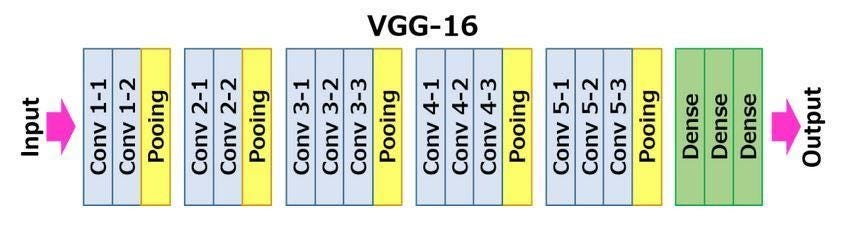

##### No Regularization

In [8]:
def VGG16 (input_shape=(224,224,3), n_class=5, input_tensor=None) :

    x_input = Input(input_shape, name="input_layer") #VGG16 input_shape by default is (224,224,3)

    #FEATURE EXTRACTION - Convolutional Layers
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv1")(x_input)
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv2")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block1_maxpool")(x)

    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv1")(x)
    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv2")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block2_maxpool")(x)

    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv1")(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv2")(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block3_maxpool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv1")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv2")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block4_pool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv1")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv2")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block5_pool")(x)

    #Make it into 1 dimension
    x = Flatten()(x)

    #CLASSIFICATION - Fully Connected Layers
    x = Dense(4096, activation=relu, name="fc1")(x) #1
    x = Dense(4096, activation=relu, name="fc2")(x) #2
    x = Dense(n_class, activation=softmax, name="predictions")(x) #3
    #5 = number of output label

    model = Model(inputs = x_input, outputs = x, name = "VGG16")

    return model

##### L1 Regularization

Place L1 regularization to the weights of the convolutional and fully connected layers

In [9]:
def VGG16_L1 (pen, input_shape=(224,224,3), n_class=5,input_tensor=None) :

    x_input = Input(input_shape, name="input_layer") #VGG16 input_shape by default is (224,224,3)

    #FEATURE EXTRACTION - Convolutional Layers
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv1", kernel_regularizer=l1(pen))(x_input)
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv2", kernel_regularizer=l1(pen))(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block1_maxpool")(x)

    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv1", kernel_regularizer=l1(pen))(x)
    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv2", kernel_regularizer=l1(pen))(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block2_maxpool")(x)

    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv1", kernel_regularizer=l1(pen))(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv2", kernel_regularizer=l1(pen))(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv3", kernel_regularizer=l1(pen))(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block3_maxpool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv1", kernel_regularizer=l1(pen))(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv2", kernel_regularizer=l1(pen))(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv3", kernel_regularizer=l1(pen))(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block4_pool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv1", kernel_regularizer=l1(pen))(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv2", kernel_regularizer=l1(pen))(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv3", kernel_regularizer=l1(pen))(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block5_pool")(x)

    #Make it into 1 dimension
    x = Flatten()(x)

    #CLASSIFICATION - Fully Connected Layers
    x = Dense(4096, activation=relu, name="fc1", kernel_regularizer=l1(pen))(x) #1
    x = Dense(4096, activation=relu, name="fc2", kernel_regularizer=l1(pen))(x) #2
    x = Dense(n_class, activation=softmax, name="predictions")(x) #3
    #5 = number of output label

    model = Model(inputs = x_input, outputs = x, name = "VGG16_L1")

    return model

##### L2 Regularization

Place L2 regularization to the weights of the convolutional and fully connected layers

In [10]:
def VGG16_L2 (pen, input_shape=(224,224,3), n_class=5, input_tensor=None) :

    x_input = Input(input_shape, name="input_layer") #VGG16 input_shape by default is (224,224,3)

    #FEATURE EXTRACTION - Convolutional Layers
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv1", kernel_regularizer=l2(pen))(x_input)
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv2", kernel_regularizer=l2(pen))(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block1_maxpool")(x)

    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv1", kernel_regularizer=l2(pen))(x)
    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv2", kernel_regularizer=l2(pen))(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block2_maxpool")(x)

    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv1", kernel_regularizer=l2(pen))(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv2", kernel_regularizer=l2(pen))(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv3", kernel_regularizer=l2(pen))(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block3_maxpool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv1", kernel_regularizer=l2(pen))(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv2", kernel_regularizer=l2(pen))(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv3", kernel_regularizer=l2(pen))(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block4_pool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv1", kernel_regularizer=l2(pen))(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv2", kernel_regularizer=l2(pen))(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv3", kernel_regularizer=l2(pen))(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block5_pool")(x)

    #Make it into 1 dimension
    x = Flatten()(x)

    #CLASSIFICATION - Fully Connected Layers
    x = Dense(4096, activation=relu, name="fc1", kernel_regularizer=l2(pen))(x) #1
    x = Dense(4096, activation=relu, name="fc2", kernel_regularizer=l2(pen))(x) #2
    x = Dense(n_class, activation=softmax, name="predictions")(x) #3
    #5 = number of output label

    model = Model(inputs = x_input, outputs = x, name = "VGG16_L2")

    return model

##### Elastic Net Regularization

In [11]:
def VGG16_L1L2 (pen1, pen2, input_shape=(224,224,3), n_class=5, input_tensor=None) :

    x_input = Input(input_shape, name="input_layer") #VGG16 input_shape by default is (224,224,3)

    #FEATURE EXTRACTION - Convolutional Layers
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv1", kernel_regularizer=l1_l2(l1=pen1, l2=pen2))(x_input)
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv2", kernel_regularizer=l1_l2(l1=pen1, l2=pen2))(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block1_maxpool")(x)

    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv1", kernel_regularizer=l1_l2(l1=pen1, l2=pen2))(x)
    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv2", kernel_regularizer=l1_l2(l1=pen1, l2=pen2))(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block2_maxpool")(x)

    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv1", kernel_regularizer=l1_l2(l1=pen1, l2=pen2))(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv2", kernel_regularizer=l1_l2(l1=pen1, l2=pen2))(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv3", kernel_regularizer=l1_l2(l1=pen1, l2=pen2))(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block3_maxpool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv1", kernel_regularizer=l1_l2(l1=pen1, l2=pen2))(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv2", kernel_regularizer=l1_l2(l1=pen1, l2=pen2))(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv3", kernel_regularizer=l1_l2(l1=pen1, l2=pen2))(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block4_pool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv1", kernel_regularizer=l1_l2(l1=pen1, l2=pen2))(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv2", kernel_regularizer=l1_l2(l1=pen1, l2=pen2))(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv3", kernel_regularizer=l1_l2(l1=pen1, l2=pen2))(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block5_pool")(x)

    #Make it into 1 dimension
    x = Flatten()(x)

    #CLASSIFICATION - Fully Connected Layers
    x = Dense(4096, activation=relu, name="fc1", kernel_regularizer=l1_l2(l1=pen1, l2=pen2))(x) #1
    x = Dense(4096, activation=relu, name="fc2", kernel_regularizer=l1_l2(l1=pen1, l2=pen2))(x) #2
    x = Dense(n_class, activation=softmax, name="predictions")(x) #3
    #5 = number of output label

    model = Model(inputs = x_input, outputs = x, name = "VGG16_L1L2")

    return model

##### Dropout Regularization

Original Paper : https://arxiv.org/pdf/1207.0580.pdf

~ Use dropout during training phase only\
~ Based on the paper, place dropout after a dense layer or fully connected layer\
~ More [recent research](http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf) has shown some value in applying dropout also to convolutional layers, although at much lower levels: p=0.1 or 0.2. Dropout was used after the activation function of each convolutional layer: CONV->RELU->DROP

In [12]:
def VGG16_Dropout (dropout_rate, input_shape=(224,224,3), n_class=5, input_tensor=None) :

    x_input = Input(input_shape, name="input_layer") #VGG16 input_shape by default is (224,224,3)

    #FEATURE EXTRACTION - Convolutional Layers
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv1")(x_input)
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv2")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block1_maxpool")(x)

    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv1")(x)
    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv2")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block2_maxpool")(x)

    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv1")(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv2")(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block3_maxpool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv1")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv2")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block4_pool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv1")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv2")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block5_pool")(x)

    #Make it into 1 dimension
    x = Flatten()(x)
    x = Dropout(dropout_rate)(x)

    #CLASSIFICATION - Fully Connected Layers
    x = Dense(4096, activation=relu, name="fc1")(x) #1
    x = Dropout(dropout_rate)(x)
    x = Dense(4096, activation=relu, name="fc2")(x) #2
    # x = Dropout(dropout_rate)(x)
    x = Dense(n_class, activation=softmax, name="predictions")(x) #3
    #5 = number of output label

    model = Model(inputs = x_input, outputs = x, name = "VGG16_Dropout")

    return model

##### Early Stopping

In [12]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min')

##### Image Augmentation

Architecture for this methods is the same as VGG16 model. No need to build the new one...Jump into the compile model

##### Batch Normalization

Paper : https://arxiv.org/pdf/1502.03167.pdf 

Based on the original paper, Batch Norm diletakkan sesudah convolutional layer dan fully connected layer.

In [14]:
def VGG16_BatchNorm (input_shape=(224,224,3), n_class=5, input_tensor=None) :

    x_input = Input(input_shape, name="input_layer") #VGG16 input_shape by default is (224,224,3)

    #FEATURE EXTRACTION - Convolutional Layers
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv1")(x_input)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv2")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block1_maxpool")(x)

    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv1")(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv2")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block2_maxpool")(x)

    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv1")(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv2")(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv3")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block3_maxpool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv1")(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv2")(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv3")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block4_pool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv1")(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv2")(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv3")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block5_pool")(x)

    #Make it into 1 dimension
    x = Flatten()(x)

    #CLASSIFICATION - Fully Connected Layers
    x = Dense(4096, activation=relu, name="fc1")(x) #1
    x = BatchNormalization()(x)
    x = Dense(4096, activation=relu, name="fc2")(x) #2
    x = BatchNormalization()(x)
    x = Dense(n_class, activation=softmax, name="predictions")(x) #3
    #5 = number of output label

    model = Model(inputs = x_input, outputs = x, name = "VGG16_BatchNorm")

    return model

#### ResNet-50

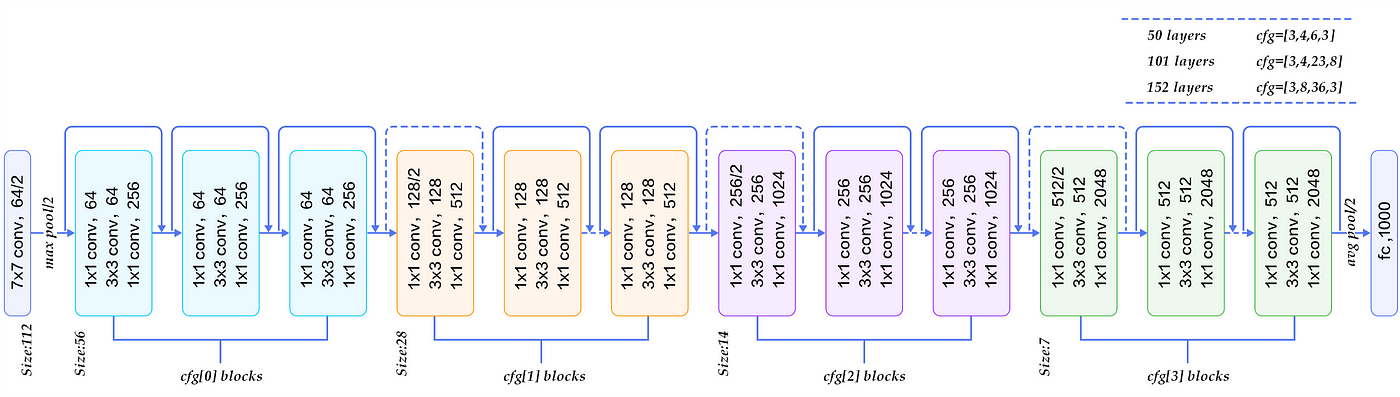

##### No Regularization

In [14]:
def residual_block(X_start, filters, name, reduce=False, res_conv2d=False):
    nb_filters_1, nb_filters_2, nb_filters_3 = filters
    strides_1 = [2,2] if reduce else [1,1]

    X = Conv2D(filters=nb_filters_1, kernel_size=[1,1], strides=strides_1, padding='same', name=name)(X_start)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_2, kernel_size=[3,3], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)

    if res_conv2d:
        X_res = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=strides_1, padding='same')(X_start)
        X_res = BatchNormalization()(X_res)
    else:
        X_res = X_start

    X = Add()([X, X_res])
    X = Activation('relu')(X)
    return X

# default (input_shape=[224, 224, 3]
def ResNet50(input_shape=(224,224,3), nb_classes=5):
    assert len(input_shape) == 3

    X_input = Input(shape=input_shape)

    # conv1
    X = Conv2D(filters=64, kernel_size=[7,7], strides=[2,2], padding='same', name='conv1')(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D([3,3], strides=[2,2])(X)

    # conv2_x
    X = residual_block(X, filters=[64, 64, 256], name='conv2_a', reduce=False, res_conv2d=True)
    X = residual_block(X, filters=[64, 64, 256], name='conv2_b')
    X = residual_block(X, filters=[64, 64, 256], name='conv2_c')

    # conv3_x
    X = residual_block(X, filters=[128, 128, 512], name='conv3_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[128, 128, 512], name='conv3_b')
    X = residual_block(X, filters=[128, 128, 512], name='conv3_c')
    X = residual_block(X, filters=[128, 128, 512], name='conv3_d')

    # conv4_x
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_b')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_c')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_d')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_e')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_f')

    # conv5_x
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_b')
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_c')

    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(units=nb_classes, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X, name = "ResNet50")

    return model

##### L1 Regularization

In [5]:
def residual_block1(X_start, filters, name, l1_reg, reduce=False, res_conv2d=False):
    nb_filters_1, nb_filters_2, nb_filters_3 = filters
    strides_1 = [2,2] if reduce else [1,1]

    X = Conv2D(filters=nb_filters_1, kernel_size=[1,1], strides=strides_1, padding='same', name=name, kernel_regularizer=l1(l1_reg))(X_start)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_2, kernel_size=[3,3], strides=[1,1], padding='same', kernel_regularizer=l1(l1_reg))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=[1,1], padding='same', kernel_regularizer=l1(l1_reg))(X)
    X = BatchNormalization()(X)

    if res_conv2d:
        X_res = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=strides_1, padding='same', kernel_regularizer=l1(l1_reg))(X_start)
        X_res = BatchNormalization()(X_res)
    else:
        X_res = X_start

    X = Add()([X, X_res])
    X = Activation('relu')(X)
    return X

# default (input_shape=[224, 224, 3]
def ResNet50_L1(l1_pen, input_shape=(224,224,3), nb_classes=5):
    assert len(input_shape) == 3

    X_input = Input(shape=input_shape)

    # conv1
    X = Conv2D(filters=64, kernel_size=[7,7], strides=[2,2], padding='same', name='conv1', kernel_regularizer=l1(l1_pen))(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D([3,3], strides=[2,2])(X)

    # conv2_x
    X = residual_block1(X, filters=[64, 64, 256], name='conv2_a', l1_reg=l1_pen, reduce=False, res_conv2d=True)
    X = residual_block1(X, filters=[64, 64, 256], name='conv2_b', l1_reg=l1_pen)
    X = residual_block1(X, filters=[64, 64, 256], name='conv2_c', l1_reg=l1_pen)

    # conv3_x
    X = residual_block1(X, filters=[128, 128, 512], name='conv3_a', l1_reg=l1_pen, reduce=True, res_conv2d=True)
    X = residual_block1(X, filters=[128, 128, 512], name='conv3_b', l1_reg=l1_pen)
    X = residual_block1(X, filters=[128, 128, 512], name='conv3_c', l1_reg=l1_pen)
    X = residual_block1(X, filters=[128, 128, 512], name='conv3_d', l1_reg=l1_pen)

    # conv4_x
    X = residual_block1(X, filters=[256, 256, 1024], name='conv4_a', l1_reg=l1_pen, reduce=True, res_conv2d=True)
    X = residual_block1(X, filters=[256, 256, 1024], name='conv4_b', l1_reg=l1_pen)
    X = residual_block1(X, filters=[256, 256, 1024], name='conv4_c', l1_reg=l1_pen)
    X = residual_block1(X, filters=[256, 256, 1024], name='conv4_d', l1_reg=l1_pen)
    X = residual_block1(X, filters=[256, 256, 1024], name='conv4_e', l1_reg=l1_pen)
    X = residual_block1(X, filters=[256, 256, 1024], name='conv4_f', l1_reg=l1_pen)

    # conv5_x
    X = residual_block1(X, filters=[512, 512, 2048], name='conv5_a', l1_reg=l1_pen, reduce=True, res_conv2d=True)
    X = residual_block1(X, filters=[512, 512, 2048], name='conv5_b', l1_reg=l1_pen)
    X = residual_block1(X, filters=[512, 512, 2048], name='conv5_c', l1_reg=l1_pen)

    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(units=nb_classes, activation='softmax', kernel_regularizer=l1(l1_pen))(X)

    model = Model(inputs = X_input, outputs = X, name = "ResNet50_L1")

    return model

##### L2 Regularization

In [6]:
def residual_block2(X_start, filters, name, l2_reg, reduce=False, res_conv2d=False):
    nb_filters_1, nb_filters_2, nb_filters_3 = filters
    strides_1 = [2,2] if reduce else [1,1]

    X = Conv2D(filters=nb_filters_1, kernel_size=[1,1], strides=strides_1, padding='same', name=name, kernel_regularizer=l2(l2_reg))(X_start)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_2, kernel_size=[3,3], strides=[1,1], padding='same', kernel_regularizer=l2(l2_reg))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=[1,1], padding='same', kernel_regularizer=l2(l2_reg))(X)
    X = BatchNormalization()(X)

    if res_conv2d:
        X_res = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=strides_1, padding='same', kernel_regularizer=l2(l2_reg))(X_start)
        X_res = BatchNormalization()(X_res)
    else:
        X_res = X_start

    X = Add()([X, X_res])
    X = Activation('relu')(X)
    return X

# default (input_shape=[224, 224, 3]
def ResNet50_L2(l2_pen, input_shape=(224,224,3), nb_classes=5):
    assert len(input_shape) == 3

    X_input = Input(shape=input_shape)

    # conv1
    X = Conv2D(filters=64, kernel_size=[7,7], strides=[2,2], padding='same', name='conv1', kernel_regularizer=l2(l2_pen))(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D([3,3], strides=[2,2])(X)

    # conv2_x
    X = residual_block2(X, filters=[64, 64, 256], name='conv2_a', l2_reg=l2_pen, reduce=False, res_conv2d=True)
    X = residual_block2(X, filters=[64, 64, 256], name='conv2_b', l2_reg=l2_pen)
    X = residual_block2(X, filters=[64, 64, 256], name='conv2_c', l2_reg=l2_pen)

    # conv3_x
    X = residual_block2(X, filters=[128, 128, 512], name='conv3_a', l2_reg=l2_pen, reduce=True, res_conv2d=True)
    X = residual_block2(X, filters=[128, 128, 512], name='conv3_b', l2_reg=l2_pen)
    X = residual_block2(X, filters=[128, 128, 512], name='conv3_c', l2_reg=l2_pen)
    X = residual_block2(X, filters=[128, 128, 512], name='conv3_d', l2_reg=l2_pen)

    # conv4_x
    X = residual_block2(X, filters=[256, 256, 1024], name='conv4_a', l2_reg=l2_pen, reduce=True, res_conv2d=True)
    X = residual_block2(X, filters=[256, 256, 1024], name='conv4_b', l2_reg=l2_pen)
    X = residual_block2(X, filters=[256, 256, 1024], name='conv4_c', l2_reg=l2_pen)
    X = residual_block2(X, filters=[256, 256, 1024], name='conv4_d', l2_reg=l2_pen)
    X = residual_block2(X, filters=[256, 256, 1024], name='conv4_e', l2_reg=l2_pen)
    X = residual_block2(X, filters=[256, 256, 1024], name='conv4_f', l2_reg=l2_pen)

    # conv5_x
    X = residual_block2(X, filters=[512, 512, 2048], name='conv5_a', l2_reg=l2_pen, reduce=True, res_conv2d=True)
    X = residual_block2(X, filters=[512, 512, 2048], name='conv5_b', l2_reg=l2_pen)
    X = residual_block2(X, filters=[512, 512, 2048], name='conv5_c', l2_reg=l2_pen)

    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(units=nb_classes, activation='softmax', kernel_regularizer=l2(l2_pen))(X)

    model = Model(inputs = X_input, outputs = X, name = "ResNet50_L2")

    return model

##### Elastic Net Regularization

In [7]:
def residual_block3(X_start, filters, name, l1_reg, l2_reg, reduce=False, res_conv2d=False):
    nb_filters_1, nb_filters_2, nb_filters_3 = filters
    strides_1 = [2,2] if reduce else [1,1]

    X = Conv2D(filters=nb_filters_1, kernel_size=[1,1], strides=strides_1, padding='same', name=name, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(X_start)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_2, kernel_size=[3,3], strides=[1,1], padding='same', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=[1,1], padding='same', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(X)
    X = BatchNormalization()(X)

    if res_conv2d:
        X_res = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=strides_1, padding='same', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(X_start)
        X_res = BatchNormalization()(X_res)
    else:
        X_res = X_start

    X = Add()([X, X_res])
    X = Activation('relu')(X)
    return X

# default (input_shape=[224, 224, 3]
def ResNet50_L1L2(l1_pen, l2_pen, input_shape=(224,224,3), nb_classes=5):
    assert len(input_shape) == 3

    X_input = Input(shape=input_shape)

    # conv1
    X = Conv2D(filters=64, kernel_size=[7,7], strides=[2,2], padding='same', name='conv1', kernel_regularizer=l1_l2(l1=l1_pen, l2=l2_pen))(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D([3,3], strides=[2,2])(X)

    # conv2_x
    X = residual_block3(X, filters=[64, 64, 256], name='conv2_a', l1_reg=l1_pen, l2_reg=l2_pen, reduce=False, res_conv2d=True)
    X = residual_block3(X, filters=[64, 64, 256], name='conv2_b', l1_reg=l1_pen, l2_reg=l2_pen)
    X = residual_block3(X, filters=[64, 64, 256], name='conv2_c', l1_reg=l1_pen, l2_reg=l2_pen)

    # conv3_x
    X = residual_block3(X, filters=[128, 128, 512], name='conv3_a', l1_reg=l1_pen, l2_reg=l2_pen, reduce=True, res_conv2d=True)
    X = residual_block3(X, filters=[128, 128, 512], name='conv3_b', l1_reg=l1_pen, l2_reg=l2_pen)
    X = residual_block3(X, filters=[128, 128, 512], name='conv3_c', l1_reg=l1_pen, l2_reg=l2_pen)
    X = residual_block3(X, filters=[128, 128, 512], name='conv3_d', l1_reg=l1_pen, l2_reg=l2_pen)

    # conv4_x
    X = residual_block3(X, filters=[256, 256, 1024], name='conv4_a', l1_reg=l1_pen, l2_reg=l2_pen, reduce=True, res_conv2d=True)
    X = residual_block3(X, filters=[256, 256, 1024], name='conv4_b', l1_reg=l1_pen, l2_reg=l2_pen)
    X = residual_block3(X, filters=[256, 256, 1024], name='conv4_c', l1_reg=l1_pen, l2_reg=l2_pen)
    X = residual_block3(X, filters=[256, 256, 1024], name='conv4_d', l1_reg=l1_pen, l2_reg=l2_pen)
    X = residual_block3(X, filters=[256, 256, 1024], name='conv4_e', l1_reg=l1_pen, l2_reg=l2_pen)
    X = residual_block3(X, filters=[256, 256, 1024], name='conv4_f', l1_reg=l1_pen, l2_reg=l2_pen)

    # conv5_x
    X = residual_block3(X, filters=[512, 512, 2048], name='conv5_a', l1_reg=l1_pen, l2_reg=l2_pen, reduce=True, res_conv2d=True)
    X = residual_block3(X, filters=[512, 512, 2048], name='conv5_b', l1_reg=l1_pen, l2_reg=l2_pen)
    X = residual_block3(X, filters=[512, 512, 2048], name='conv5_c', l1_reg=l1_pen, l2_reg=l2_pen)

    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(units=nb_classes, activation='softmax', kernel_regularizer=l1_l2(l1=l1_pen, l2=l2_pen))(X)

    model = Model(inputs = X_input, outputs = X, name = "ResNet50_L1L2")

    return model

##### Dropout Regularization

In [8]:
def residual_block4(X_start, filters, name,reduce=False, res_conv2d=False):
    nb_filters_1, nb_filters_2, nb_filters_3 = filters
    strides_1 = [2,2] if reduce else [1,1]

    X = Conv2D(filters=nb_filters_1, kernel_size=[1,1], strides=strides_1, padding='same', name=name)(X_start)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_2, kernel_size=[3,3], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)

    if res_conv2d:
        X_res = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=strides_1, padding='same')(X_start)
        X_res = BatchNormalization()(X_res)
    else:
        X_res = X_start

    X = Add()([X, X_res])
    X = Activation('relu')(X)
    return X

# default (input_shape=[224, 224, 3]
def ResNet50_Dropout(dropout_rate, input_shape=(224,224,3), nb_classes=5):
    assert len(input_shape) == 3

    X_input = Input(shape=input_shape)

    # conv1
    X = Conv2D(filters=64, kernel_size=[7,7], strides=[2,2], padding='same', name='conv1')(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D([3,3], strides=[2,2])(X)

    # conv2_x
    X = residual_block4(X, filters=[64, 64, 256], name='conv2_a', reduce=False, res_conv2d=True)
    X = residual_block4(X, filters=[64, 64, 256], name='conv2_b')
    X = residual_block4(X, filters=[64, 64, 256], name='conv2_c')

    # conv3_x
    X = residual_block4(X, filters=[128, 128, 512], name='conv3_a', reduce=True, res_conv2d=True)
    X = residual_block4(X, filters=[128, 128, 512], name='conv3_b')
    X = residual_block4(X, filters=[128, 128, 512], name='conv3_c')
    X = residual_block4(X, filters=[128, 128, 512], name='conv3_d')

    # conv4_x
    X = residual_block4(X, filters=[256, 256, 1024], name='conv4_a', reduce=True, res_conv2d=True)
    X = residual_block4(X, filters=[256, 256, 1024], name='conv4_b')
    X = residual_block4(X, filters=[256, 256, 1024], name='conv4_c')
    X = residual_block4(X, filters=[256, 256, 1024], name='conv4_d')
    X = residual_block4(X, filters=[256, 256, 1024], name='conv4_e')
    X = residual_block4(X, filters=[256, 256, 1024], name='conv4_f')

    # conv5_x
    X = residual_block4(X, filters=[512, 512, 2048], name='conv5_a', reduce=True, res_conv2d=True)
    X = residual_block4(X, filters=[512, 512, 2048], name='conv5_b')
    X = residual_block4(X, filters=[512, 512, 2048], name='conv5_c')

    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Flatten()(X)
    X = Dropout(dropout_rate)(X)

    X = Dense(units=nb_classes, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X, name = "ResNet50")

    return model

##### Early Stopping

Architecture for this methods is the same as ResNet-50 original model. No need to build the new one...Jump into the compile model

##### Image Augmentation

Architecture for this methods is the same as ResNet-50 original model. No need to build the new one...Jump into the compile model

##### Batch Normalization

In [9]:
def residual_block5(X_start, filters, name,reduce=False, res_conv2d=False):
    nb_filters_1, nb_filters_2, nb_filters_3 = filters
    strides_1 = [2,2] if reduce else [1,1]

    X = Conv2D(filters=nb_filters_1, kernel_size=[1,1], strides=strides_1, padding='same', name=name)(X_start)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_2, kernel_size=[3,3], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)

    if res_conv2d:
        X_res = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=strides_1, padding='same')(X_start)
        X_res = BatchNormalization()(X_res)
    else:
        X_res = X_start

    X = Add()([X, X_res])
    X = Activation('relu')(X)
    return X

# default (input_shape=[224, 224, 3]
def ResNet50_BatchNorm(input_shape=(224,224,3), nb_classes=5):
    assert len(input_shape) == 3

    X_input = Input(shape=input_shape)

    # conv1
    X = Conv2D(filters=64, kernel_size=[7,7], strides=[2,2], padding='same', name='conv1')(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D([3,3], strides=[2,2])(X)
    X = BatchNormalization()(X)

    # conv2_x
    X = residual_block5(X, filters=[64, 64, 256], name='conv2_a', reduce=False, res_conv2d=True)
    X = residual_block5(X, filters=[64, 64, 256], name='conv2_b')
    X = residual_block5(X, filters=[64, 64, 256], name='conv2_c')
    X = BatchNormalization()(X)

    # conv3_x
    X = residual_block5(X, filters=[128, 128, 512], name='conv3_a', reduce=True, res_conv2d=True)
    X = residual_block5(X, filters=[128, 128, 512], name='conv3_b')
    X = residual_block5(X, filters=[128, 128, 512], name='conv3_c')
    X = residual_block5(X, filters=[128, 128, 512], name='conv3_d')
    X = BatchNormalization()(X)

    # conv4_x
    X = residual_block5(X, filters=[256, 256, 1024], name='conv4_a', reduce=True, res_conv2d=True)
    X = residual_block5(X, filters=[256, 256, 1024], name='conv4_b')
    X = residual_block5(X, filters=[256, 256, 1024], name='conv4_c')
    X = residual_block5(X, filters=[256, 256, 1024], name='conv4_d')
    X = residual_block5(X, filters=[256, 256, 1024], name='conv4_e')
    X = residual_block5(X, filters=[256, 256, 1024], name='conv4_f')
    X = BatchNormalization()(X)

    # conv5_x
    X = residual_block5(X, filters=[512, 512, 2048], name='conv5_a', reduce=True, res_conv2d=True)
    X = residual_block5(X, filters=[512, 512, 2048], name='conv5_b')
    X = residual_block5(X, filters=[512, 512, 2048], name='conv5_c')
    X = BatchNormalization()(X)

    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Flatten()(X)
    X = BatchNormalization()(X)

    X = Dense(units=nb_classes, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X, name = "ResNet50")

    return model

---

### Compile & Train the Model

#### VGG16

In [20]:
model_VGG = VGG16()
model_VGGL1 = VGG16_L1(0.0001)
model_VGGL2 = VGG16_L2(0.0001)
model_VGGL1L2 = VGG16_L1L2(0.0001, 0.0001)
model_VGGDropout = VGG16_Dropout(0.25)
model_VGGEarStop = VGG16()
model_VGGAug = VGG16()
model_VGGBatchNorm = VGG16_BatchNorm()

In [21]:
model_VGG.summary()
# plot_model(model_VGG, to_file='/Calvino/TA')

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_maxpool (MaxPooling2  (None, 112, 112, 64)     0         
 D)                                                              
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                             

In [21]:
model_VGG.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])
model_VGGL1.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])
model_VGGL2.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])
model_VGGL1L2.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])
model_VGGDropout.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])
model_VGGEarStop.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])
model_VGGAug.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])
model_VGGBatchNorm.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [18]:
steps_per_epoch = 50
epochs = 30
validation_steps = 15

In [23]:
history_VGG = model_VGG.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      verbose=1)

Epoch 1/30
50/50 [==============================] - 101s 2s/step - loss: 1.1194 - accuracy: 0.6650 - val_loss: 0.9043 - val_accuracy: 0.7583
Epoch 2/30
50/50 [==============================] - 99s 2s/step - loss: 0.9122 - accuracy: 0.7300 - val_loss: 0.8537 - val_accuracy: 0.7500
Epoch 3/30
50/50 [==============================] - 99s 2s/step - loss: 0.9418 - accuracy: 0.7075 - val_loss: 0.9460 - val_accuracy: 0.7000
Epoch 4/30
50/50 [==============================] - 99s 2s/step - loss: 0.7713 - accuracy: 0.7750 - val_loss: 0.9460 - val_accuracy: 0.7417
Epoch 5/30
50/50 [==============================] - 228s 5s/step - loss: 0.9309 - accuracy: 0.7350 - val_loss: 0.9495 - val_accuracy: 0.7333
Epoch 6/30
50/50 [==============================] - 343s 7s/step - loss: 0.8956 - accuracy: 0.7225 - val_loss: 0.8590 - val_accuracy: 0.7667
Epoch 7/30
50/50 [==============================] - 384s 8s/step - loss: 0.7613 - accuracy: 0.7925 - val_loss: 1.0104 - val_accuracy: 0.6833
Epoch 8/30
50/50

In [24]:
history_VGGL1 = model_VGGL1.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      verbose=1)

Epoch 1/30
50/50 [==============================] - 377s 7s/step - loss: 90.4478 - accuracy: 0.7000 - val_loss: 65.7461 - val_accuracy: 0.7000
Epoch 2/30
50/50 [==============================] - 376s 8s/step - loss: 47.9191 - accuracy: 0.7025 - val_loss: 32.0926 - val_accuracy: 0.7833
Epoch 3/30
50/50 [==============================] - 377s 8s/step - loss: 23.0313 - accuracy: 0.7225 - val_loss: 16.4493 - val_accuracy: 0.7583
Epoch 4/30
50/50 [==============================] - 375s 8s/step - loss: 13.0218 - accuracy: 0.7375 - val_loss: 9.9791 - val_accuracy: 0.7500
Epoch 5/30
50/50 [==============================] - 379s 8s/step - loss: 8.1557 - accuracy: 0.7400 - val_loss: 6.6598 - val_accuracy: 0.7500
Epoch 6/30
50/50 [==============================] - 378s 8s/step - loss: 5.9492 - accuracy: 0.7225 - val_loss: 5.3763 - val_accuracy: 0.7333
Epoch 7/30
50/50 [==============================] - 374s 7s/step - loss: 4.9253 - accuracy: 0.7625 - val_loss: 4.6648 - val_accuracy: 0.6750
Epoch 

In [25]:
history_VGGL2 = model_VGGL2.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      verbose=1)

Epoch 1/30
50/50 [==============================] - 105s 2s/step - loss: 2.3475 - accuracy: 0.7325 - val_loss: 1.9151 - val_accuracy: 0.7333
Epoch 2/30
50/50 [==============================] - 104s 2s/step - loss: 1.8221 - accuracy: 0.7000 - val_loss: 1.5844 - val_accuracy: 0.7500
Epoch 3/30
50/50 [==============================] - 106s 2s/step - loss: 1.4787 - accuracy: 0.7500 - val_loss: 1.6305 - val_accuracy: 0.6833
Epoch 4/30
50/50 [==============================] - 104s 2s/step - loss: 1.3887 - accuracy: 0.7300 - val_loss: 1.3525 - val_accuracy: 0.7250
Epoch 5/30
50/50 [==============================] - 104s 2s/step - loss: 1.3974 - accuracy: 0.7100 - val_loss: 1.1933 - val_accuracy: 0.7583
Epoch 6/30
50/50 [==============================] - 104s 2s/step - loss: 1.2757 - accuracy: 0.7225 - val_loss: 1.4611 - val_accuracy: 0.6417
Epoch 7/30
50/50 [==============================] - 104s 2s/step - loss: 1.3227 - accuracy: 0.7150 - val_loss: 1.2479 - val_accuracy: 0.7083
Epoch 8/30
50

In [30]:
model_VGG.save("VGG16.h5")
model_VGGL1.save("VGG16_L1.h5")
model_VGGL2.save("VGG16_L2.h5")

In [23]:
history_VGGL1L2 = model_VGGL1L2.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      verbose=1)

Epoch 1/30
50/50 [==============================] - 220s 4s/step - loss: 90.8107 - accuracy: 0.7125 - val_loss: 65.0244 - val_accuracy: 0.7750
Epoch 2/30
50/50 [==============================] - 118s 2s/step - loss: 46.7242 - accuracy: 0.7225 - val_loss: 30.7364 - val_accuracy: 0.7500
Epoch 3/30
50/50 [==============================] - 117s 2s/step - loss: 21.5259 - accuracy: 0.7475 - val_loss: 14.9980 - val_accuracy: 0.7667
Epoch 4/30
50/50 [==============================] - 118s 2s/step - loss: 11.7130 - accuracy: 0.7200 - val_loss: 8.8602 - val_accuracy: 0.7250
Epoch 5/30
50/50 [==============================] - 116s 2s/step - loss: 7.0581 - accuracy: 0.7225 - val_loss: 5.4847 - val_accuracy: 0.7500
Epoch 6/30
50/50 [==============================] - 118s 2s/step - loss: 4.8909 - accuracy: 0.7475 - val_loss: 4.4773 - val_accuracy: 0.7000
Epoch 7/30
50/50 [==============================] - 117s 2s/step - loss: 4.0955 - accuracy: 0.7175 - val_loss: 3.5540 - val_accuracy: 0.8000
Epoch 

In [24]:
model_VGGL1L2.save("VGG16_L1L2.h5")

In [25]:
history_VGGDropout = model_VGGDropout.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      verbose=1)

Epoch 1/30
50/50 [==============================] - 103s 2s/step - loss: 0.9103 - accuracy: 0.7550 - val_loss: 0.8002 - val_accuracy: 0.7583
Epoch 2/30
50/50 [==============================] - 98s 2s/step - loss: 0.8981 - accuracy: 0.7350 - val_loss: 0.9164 - val_accuracy: 0.7583
Epoch 3/30
50/50 [==============================] - 98s 2s/step - loss: 0.9178 - accuracy: 0.7250 - val_loss: 0.9611 - val_accuracy: 0.6917
Epoch 4/30
50/50 [==============================] - 97s 2s/step - loss: 0.8190 - accuracy: 0.7700 - val_loss: 0.9786 - val_accuracy: 0.6667
Epoch 5/30
50/50 [==============================] - 98s 2s/step - loss: 0.8783 - accuracy: 0.7375 - val_loss: 0.9733 - val_accuracy: 0.7083
Epoch 6/30
50/50 [==============================] - 98s 2s/step - loss: 0.9589 - accuracy: 0.7025 - val_loss: 0.9091 - val_accuracy: 0.7500
Epoch 7/30
50/50 [==============================] - 98s 2s/step - loss: 0.9060 - accuracy: 0.7200 - val_loss: 0.7998 - val_accuracy: 0.7833
Epoch 8/30
50/50 [=

In [26]:
model_VGGDropout.save("VGG16_Dropout.h5")

In [37]:
history_VGGEarlyStopping = model_VGGEarStop.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      callbacks=[early_stopping],
      verbose=1)

Epoch 1/30
50/50 [==============================] - 104s 2s/step - loss: 1.0683 - accuracy: 0.7150 - val_loss: 0.8928 - val_accuracy: 0.7417
Epoch 2/30
50/50 [==============================] - 101s 2s/step - loss: 0.8694 - accuracy: 0.7400 - val_loss: 0.7742 - val_accuracy: 0.7667
Epoch 3/30
50/50 [==============================] - 98s 2s/step - loss: 0.8609 - accuracy: 0.7625 - val_loss: 1.1505 - val_accuracy: 0.6333
Epoch 4/30
50/50 [==============================] - 98s 2s/step - loss: 0.7985 - accuracy: 0.7550 - val_loss: 0.9032 - val_accuracy: 0.7333
Epoch 4: early stopping


In [38]:
model_VGGEarStop.save("VGG16_EarlyStopping.h5")

In [39]:
history_VGGAugmentation = model_VGGAug.fit(
    train_aug_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = valid_generator,
    validation_steps = validation_steps,
    verbose=1
)

Epoch 1/30
50/50 [==============================] - 103s 2s/step - loss: 1.3070 - accuracy: 0.7050 - val_loss: 0.8493 - val_accuracy: 0.7750
Epoch 2/30
50/50 [==============================] - 98s 2s/step - loss: 0.8327 - accuracy: 0.7550 - val_loss: 0.8544 - val_accuracy: 0.7250
Epoch 3/30
50/50 [==============================] - 98s 2s/step - loss: 0.8965 - accuracy: 0.7475 - val_loss: 0.9962 - val_accuracy: 0.6917
Epoch 4/30
50/50 [==============================] - 98s 2s/step - loss: 0.8961 - accuracy: 0.7200 - val_loss: 0.8717 - val_accuracy: 0.7417
Epoch 5/30
50/50 [==============================] - 100s 2s/step - loss: 0.9714 - accuracy: 0.6975 - val_loss: 0.9677 - val_accuracy: 0.7000
Epoch 6/30
50/50 [==============================] - 98s 2s/step - loss: 0.9148 - accuracy: 0.7150 - val_loss: 0.9218 - val_accuracy: 0.7500
Epoch 7/30
50/50 [==============================] - 100s 2s/step - loss: 0.8923 - accuracy: 0.7375 - val_loss: 0.8145 - val_accuracy: 0.7500
Epoch 8/30
50/50 

In [40]:
model_VGGAug.save("VGG16_Augmentation.h5")

In [41]:
history_VGGBatchNorm = model_VGGBatchNorm.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = valid_generator,
    validation_steps = validation_steps,
    verbose=1
)

Epoch 1/30
50/50 [==============================] - 413s 8s/step - loss: 3.5368 - accuracy: 0.3100 - val_loss: 4.1237 - val_accuracy: 0.0250
Epoch 2/30
50/50 [==============================] - 293s 6s/step - loss: 3.0832 - accuracy: 0.3125 - val_loss: 3.9290 - val_accuracy: 0.0000e+00
Epoch 3/30
50/50 [==============================] - 112s 2s/step - loss: 2.2164 - accuracy: 0.3600 - val_loss: 2.4116 - val_accuracy: 0.7583
Epoch 4/30
50/50 [==============================] - 112s 2s/step - loss: 1.9472 - accuracy: 0.4125 - val_loss: 3.0841 - val_accuracy: 0.7833
Epoch 5/30
50/50 [==============================] - 112s 2s/step - loss: 1.8105 - accuracy: 0.4650 - val_loss: 1.9755 - val_accuracy: 0.1833
Epoch 6/30
50/50 [==============================] - 112s 2s/step - loss: 1.6405 - accuracy: 0.4750 - val_loss: 6.0893 - val_accuracy: 0.0250
Epoch 7/30
50/50 [==============================] - 112s 2s/step - loss: 1.3162 - accuracy: 0.5875 - val_loss: 1.4116 - val_accuracy: 0.5333
Epoch 8/3

In [42]:
model_VGGBatchNorm.save("VGG16_BatchNorm.h5")

#### ResNet-50

In [ ]:
model_ResNet50 = ResNet50()
model_ResNet50L1 = ResNet50_L1(0.0001)
model_ResNet50L2 = ResNet50_L2(0.0001)
model_ResNet50L1L2 = ResNet50_L1L2(0.0001, 0.0001)
model_ResNet50Dropout = ResNet50_Dropout(0.25)
model_ResNet50EarStop = ResNet50()
model_ResNet50Aug = ResNet50()
model_ResNet50BatchNorm = ResNet50_BatchNorm()

In [16]:
model_ResNet50EarStop = ResNet50()
model_ResNet50EarStop.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [ ]:
model_ResNet50.summary()
# plot_model(model_ResNet50, to_file='/Calvino/TA/resnet50.png')

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_48 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['input_48[0][0]']               
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 112, 112, 64  256         ['conv1[0][0]']                  
                                )                                                          

In [11]:
model_ResNet50.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])
model_ResNet50L1.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])
model_ResNet50L2.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])
model_ResNet50L1L2.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])
model_ResNet50Dropout.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])
model_ResNet50EarStop.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])
model_ResNet50Aug.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])
model_ResNet50BatchNorm.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [17]:
history_ResNet50 = model_ResNet50.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      verbose=1)

Epoch 1/30
50/50 [==============================] - 54s 1s/step - loss: 1.1439 - accuracy: 0.6925 - val_loss: 1.1799 - val_accuracy: 0.7500
Epoch 2/30
50/50 [==============================] - 51s 1s/step - loss: 1.1269 - accuracy: 0.6800 - val_loss: 1.1199 - val_accuracy: 0.7000
Epoch 3/30
50/50 [==============================] - 52s 1s/step - loss: 1.0416 - accuracy: 0.7075 - val_loss: 1.2035 - val_accuracy: 0.7083
Epoch 4/30
50/50 [==============================] - 51s 1s/step - loss: 0.8824 - accuracy: 0.7550 - val_loss: 0.9032 - val_accuracy: 0.7917
Epoch 5/30
50/50 [==============================] - 51s 1s/step - loss: 0.8701 - accuracy: 0.7375 - val_loss: 0.8643 - val_accuracy: 0.7333
Epoch 6/30
50/50 [==============================] - 51s 1s/step - loss: 0.9756 - accuracy: 0.7200 - val_loss: 1.0576 - val_accuracy: 0.7417
Epoch 7/30
50/50 [==============================] - 52s 1s/step - loss: 0.9349 - accuracy: 0.7525 - val_loss: 1.1435 - val_accuracy: 0.7250
Epoch 8/30
50/50 [==

In [18]:
model_ResNet50.save("ResNet50.h5")

In [19]:
history_ResNet50L1 = model_ResNet50L1.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      verbose=1)

Epoch 1/30
50/50 [==============================] - 55s 1s/step - loss: 53.4873 - accuracy: 0.6300 - val_loss: 52.7794 - val_accuracy: 0.7417
Epoch 2/30
50/50 [==============================] - 51s 1s/step - loss: 52.5378 - accuracy: 0.6950 - val_loss: 52.2238 - val_accuracy: 0.7833
Epoch 3/30
50/50 [==============================] - 51s 1s/step - loss: 52.0057 - accuracy: 0.7375 - val_loss: 51.9172 - val_accuracy: 0.7750
Epoch 4/30
50/50 [==============================] - 51s 1s/step - loss: 51.6244 - accuracy: 0.6400 - val_loss: 51.2305 - val_accuracy: 0.7250
Epoch 5/30
50/50 [==============================] - 52s 1s/step - loss: 50.7712 - accuracy: 0.7500 - val_loss: 50.4930 - val_accuracy: 0.7500
Epoch 6/30
50/50 [==============================] - 51s 1s/step - loss: 50.2030 - accuracy: 0.7350 - val_loss: 50.1659 - val_accuracy: 0.7000
Epoch 7/30
50/50 [==============================] - 51s 1s/step - loss: 49.5965 - accuracy: 0.7075 - val_loss: 48.9295 - val_accuracy: 0.8333
Epoch 

In [20]:
model_ResNet50L1.save("ResNet50_L1.h5")

In [21]:
history_ResNet50L2 = model_ResNet50L2.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      verbose=1)

Epoch 1/30
50/50 [==============================] - 56s 1s/step - loss: 2.9774 - accuracy: 0.7075 - val_loss: 2.9756 - val_accuracy: 0.7750
Epoch 2/30
50/50 [==============================] - 93s 2s/step - loss: 3.1187 - accuracy: 0.6900 - val_loss: 2.8382 - val_accuracy: 0.7000
Epoch 3/30
50/50 [==============================] - 155s 3s/step - loss: 2.8015 - accuracy: 0.7175 - val_loss: 2.8136 - val_accuracy: 0.7083
Epoch 4/30
50/50 [==============================] - 153s 3s/step - loss: 2.6983 - accuracy: 0.7475 - val_loss: 3.0641 - val_accuracy: 0.4833
Epoch 5/30
50/50 [==============================] - 155s 3s/step - loss: 2.7997 - accuracy: 0.7150 - val_loss: 2.7424 - val_accuracy: 0.7333
Epoch 6/30
50/50 [==============================] - 151s 3s/step - loss: 2.7172 - accuracy: 0.7350 - val_loss: 2.8049 - val_accuracy: 0.7000
Epoch 7/30
50/50 [==============================] - 153s 3s/step - loss: 2.8036 - accuracy: 0.6800 - val_loss: 2.7728 - val_accuracy: 0.7417
Epoch 8/30
50/5

In [22]:
model_ResNet50L2.save("ResNet50_L2.h5")

In [23]:
history_ResNet50L1L2 = model_ResNet50L1L2.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      verbose=1)

Epoch 1/30
50/50 [==============================] - 157s 3s/step - loss: 54.8088 - accuracy: 0.7325 - val_loss: 54.5487 - val_accuracy: 0.7333
Epoch 2/30
50/50 [==============================] - 147s 3s/step - loss: 54.3199 - accuracy: 0.7025 - val_loss: 53.9171 - val_accuracy: 0.7583
Epoch 3/30
50/50 [==============================] - 145s 3s/step - loss: 53.9141 - accuracy: 0.6925 - val_loss: 53.6865 - val_accuracy: 0.8083
Epoch 4/30
50/50 [==============================] - 147s 3s/step - loss: 53.3104 - accuracy: 0.7025 - val_loss: 52.9912 - val_accuracy: 0.7667
Epoch 5/30
50/50 [==============================] - 146s 3s/step - loss: 52.8369 - accuracy: 0.6850 - val_loss: 53.5754 - val_accuracy: 0.1417
Epoch 6/30
50/50 [==============================] - 149s 3s/step - loss: 52.2242 - accuracy: 0.7300 - val_loss: 52.6949 - val_accuracy: 0.0250
Epoch 7/30
50/50 [==============================] - 147s 3s/step - loss: 51.7511 - accuracy: 0.6925 - val_loss: 51.5974 - val_accuracy: 0.6500

In [24]:
model_ResNet50L1L2.save("ResNet50_L1L2.h5")

In [25]:
history_ResNet50Dropout = model_ResNet50Dropout.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      verbose=1)

Epoch 1/30
50/50 [==============================] - 149s 3s/step - loss: 1.3367 - accuracy: 0.6125 - val_loss: 1.0416 - val_accuracy: 0.7917
Epoch 2/30
50/50 [==============================] - 141s 3s/step - loss: 1.2391 - accuracy: 0.6625 - val_loss: 1.2426 - val_accuracy: 0.7917
Epoch 3/30
50/50 [==============================] - 140s 3s/step - loss: 1.0438 - accuracy: 0.7150 - val_loss: 1.5305 - val_accuracy: 0.1000
Epoch 4/30
50/50 [==============================] - 142s 3s/step - loss: 1.2541 - accuracy: 0.6425 - val_loss: 1.0469 - val_accuracy: 0.7250
Epoch 5/30
50/50 [==============================] - 141s 3s/step - loss: 1.2006 - accuracy: 0.6650 - val_loss: 1.2688 - val_accuracy: 0.1333
Epoch 6/30
50/50 [==============================] - 140s 3s/step - loss: 1.1879 - accuracy: 0.6775 - val_loss: 0.8258 - val_accuracy: 0.7500
Epoch 7/30
50/50 [==============================] - 140s 3s/step - loss: 0.9586 - accuracy: 0.7250 - val_loss: 0.9280 - val_accuracy: 0.7667
Epoch 8/30
50

In [26]:
model_ResNet50Dropout.save("ResNet50_Dropout.h5")

In [19]:
history_ResNet50EarlyStopping = model_ResNet50EarStop.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      callbacks=[early_stopping],
      verbose=1)

Epoch 1/30
50/50 [==============================] - 57s 1s/step - loss: 1.2560 - accuracy: 0.6800 - val_loss: 1.3887 - val_accuracy: 0.1500
Epoch 2/30
50/50 [==============================] - 54s 1s/step - loss: 1.1296 - accuracy: 0.6775 - val_loss: 1.3897 - val_accuracy: 0.1833
Epoch 3/30
50/50 [==============================] - 91s 2s/step - loss: 1.0975 - accuracy: 0.6775 - val_loss: 1.3709 - val_accuracy: 0.6167
Epoch 4/30
50/50 [==============================] - 88s 2s/step - loss: 1.0195 - accuracy: 0.7150 - val_loss: 0.9634 - val_accuracy: 0.8000
Epoch 5/30
50/50 [==============================] - 53s 1s/step - loss: 1.1018 - accuracy: 0.6800 - val_loss: 1.1023 - val_accuracy: 0.6500
Epoch 6/30
50/50 [==============================] - 52s 1s/step - loss: 1.0308 - accuracy: 0.7200 - val_loss: 1.1492 - val_accuracy: 0.7250
Epoch 6: early stopping


In [30]:
model_ResNet50EarStop.save("ResNet50_EarlyStopping.h5")

In [31]:
history_ResNet50Augmentation = model_ResNet50Aug.fit(
      train_aug_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      verbose=1)

Epoch 1/30
50/50 [==============================] - 163s 3s/step - loss: 1.3145 - accuracy: 0.6600 - val_loss: 1.0210 - val_accuracy: 0.7250
Epoch 2/30
50/50 [==============================] - 160s 3s/step - loss: 1.2188 - accuracy: 0.6325 - val_loss: 0.9689 - val_accuracy: 0.7167
Epoch 3/30
50/50 [==============================] - 157s 3s/step - loss: 1.0951 - accuracy: 0.7025 - val_loss: 1.0610 - val_accuracy: 0.7167
Epoch 4/30
50/50 [==============================] - 159s 3s/step - loss: 1.1513 - accuracy: 0.6700 - val_loss: 1.3884 - val_accuracy: 0.1167
Epoch 5/30
50/50 [==============================] - 162s 3s/step - loss: 1.0512 - accuracy: 0.7375 - val_loss: 0.8059 - val_accuracy: 0.7750
Epoch 6/30
50/50 [==============================] - 159s 3s/step - loss: 0.9665 - accuracy: 0.7425 - val_loss: 1.1975 - val_accuracy: 0.6000
Epoch 7/30
50/50 [==============================] - 159s 3s/step - loss: 1.0690 - accuracy: 0.7025 - val_loss: 1.1180 - val_accuracy: 0.5750
Epoch 8/30
50

In [32]:
model_ResNet50Aug.save("ResNet50_Augmentation.h5")

In [33]:
history_ResNet50BatchNorm = model_ResNet50BatchNorm.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      verbose=1)

Epoch 1/30
50/50 [==============================] - 56s 1s/step - loss: 1.9623 - accuracy: 0.2925 - val_loss: 1.7016 - val_accuracy: 0.1167
Epoch 2/30
50/50 [==============================] - 98s 2s/step - loss: 1.6792 - accuracy: 0.3550 - val_loss: 1.1714 - val_accuracy: 0.6667
Epoch 3/30
50/50 [==============================] - 154s 3s/step - loss: 1.4472 - accuracy: 0.4775 - val_loss: 1.0415 - val_accuracy: 0.7167
Epoch 4/30
50/50 [==============================] - 154s 3s/step - loss: 1.3166 - accuracy: 0.5425 - val_loss: 0.9338 - val_accuracy: 0.7250
Epoch 5/30
50/50 [==============================] - 154s 3s/step - loss: 1.2140 - accuracy: 0.5950 - val_loss: 1.2085 - val_accuracy: 0.6750
Epoch 6/30
50/50 [==============================] - 154s 3s/step - loss: 1.1696 - accuracy: 0.6225 - val_loss: 1.0316 - val_accuracy: 0.7500
Epoch 7/30
50/50 [==============================] - 156s 3s/step - loss: 1.1375 - accuracy: 0.6575 - val_loss: 1.0651 - val_accuracy: 0.7833
Epoch 8/30
50/5

In [34]:
model_ResNet50BatchNorm.save("ResNet50_BatchNorm.h5")

---

### Evaluate

In [2]:
from keras.models import load_model

In [21]:
def show_accuracy(history, model, reg):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model + ' ' + reg + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [22]:
def show_loss(history, model, reg):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model + ' ' + reg + ' Loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

#### VGG16

In [44]:
loaded_vgg16 = load_model('VGG16.h5')

VGG16_loss, VGG16_accuracy = loaded_vgg16.evaluate(train_generator)
print("VGG16 train loss : ", VGG16_loss)
print("VGG16 train accuracy : ", VGG16_accuracy)

50/50 [==============================] - 28s 565ms/step - loss: 0.9760 - accuracy: 0.7000
VGG16 train loss :  0.975964367389679
VGG16 train accuracy :  0.699999988079071


In [48]:
VGG16_loss, VGG16_accuracy = loaded_vgg16.evaluate(test_generator)
print("VGG16 test loss : ", VGG16_loss)
print("VGG16 test accuracy : ", VGG16_accuracy)

50/50 [==============================] - 31s 617ms/step - loss: 0.8714 - accuracy: 0.7375
VGG16 test loss :  0.8713786602020264
VGG16 test accuracy :  0.737500011920929


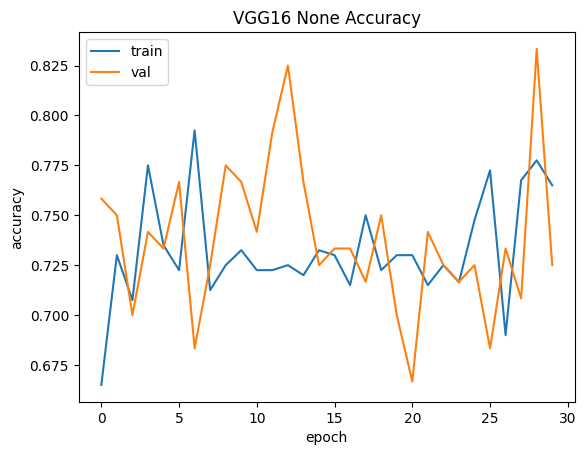

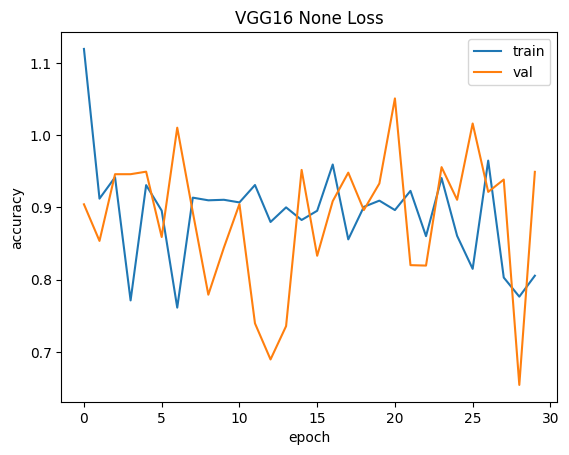

In [47]:
show_accuracy(history_VGG, 'VGG16', 'None')
show_loss(history_VGG, 'VGG16', 'None')

In [50]:
loaded_vgg16l1 = load_model('VGG16_L1.h5')

VGG16_L1_loss, VGG16_L1_accuracy = loaded_vgg16l1.evaluate(train_generator)
print("VGG16 train L1 loss : ", VGG16_L1_loss)
print("VGG16 train L1 accuracy : ", VGG16_L1_accuracy)

50/50 [==============================] - 30s 595ms/step - loss: 1.4615 - accuracy: 0.7250
VGG16 train L1 loss :  1.4614726305007935
VGG16 train L1 accuracy :  0.7250000238418579


In [53]:
VGG16_L1_loss, VGG16_L1_accuracy = loaded_vgg16l1.evaluate(test_generator)
print("VGG16 test L1 loss : ", VGG16_L1_loss)
print("VGG16 test L1 accuracy : ", VGG16_L1_accuracy)

50/50 [==============================] - 32s 649ms/step - loss: 1.3571 - accuracy: 0.7675
VGG16 test L1 loss :  1.3571134805679321
VGG16 test L1 accuracy :  0.7674999833106995


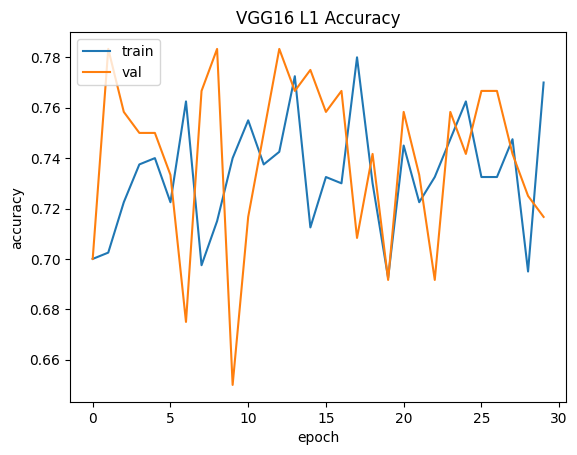

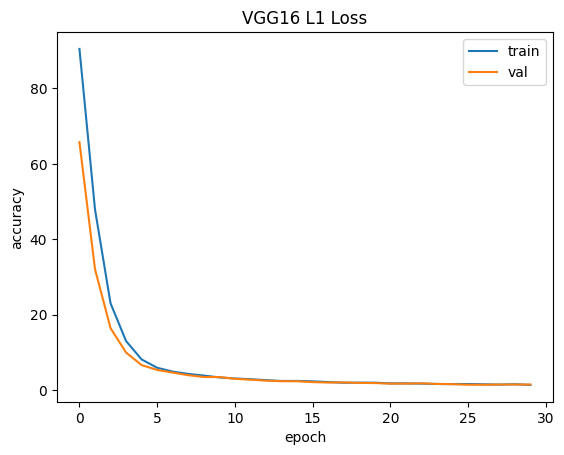

In [51]:
show_accuracy(history_VGGL1, 'VGG16', 'L1')
show_loss(history_VGGL1, 'VGG16', 'L1')

In [76]:
loaded_vggl2 = load_model('VGG16_L2.h5')

VGG16_L2_loss, VGG16_L2_accuracy = loaded_vggl2.evaluate(train_generator)
print("VGG16 train L2 loss : ", VGG16_L2_loss)
print("VGG16 train L2 accuracy : ", VGG16_L2_accuracy)

50/50 [==============================] - 28s 558ms/step - loss: 1.0575 - accuracy: 0.7375
VGG16 train L2 loss :  1.0575261116027832
VGG16 train L2 accuracy :  0.737500011920929


In [77]:
VGG16_L2_loss, VGG16_L2_accuracy = loaded_vggl2.evaluate(test_generator)
print("VGG16 test L2 loss : ", VGG16_L2_loss)
print("VGG16 test L2 accuracy : ", VGG16_L2_accuracy)

50/50 [==============================] - 28s 566ms/step - loss: 1.0691 - accuracy: 0.7225
VGG16 test L2 loss :  1.0690912008285522
VGG16 test L2 accuracy :  0.7225000262260437


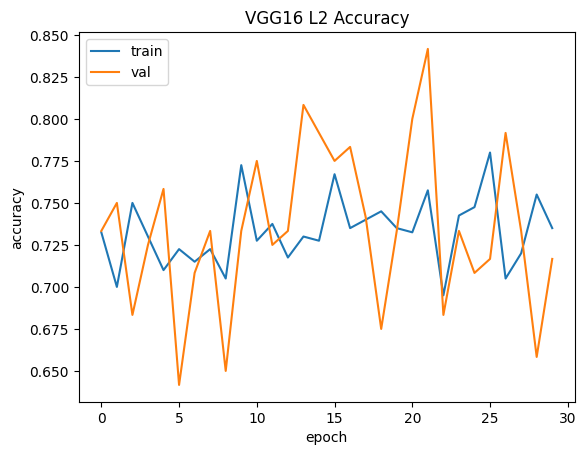

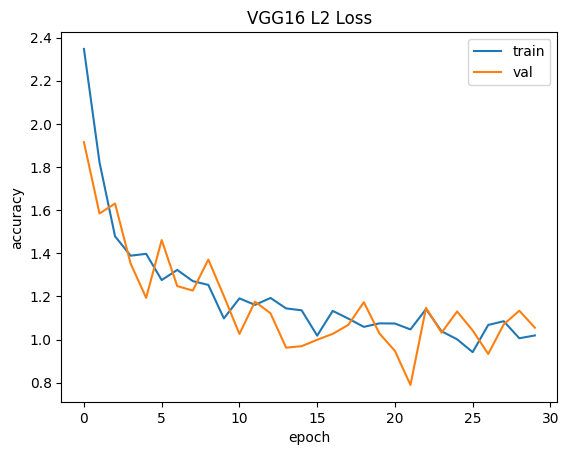

In [52]:
show_accuracy(history_VGGL2, 'VGG16', 'L2')
show_loss(history_VGGL2, 'VGG16', 'L2')

In [31]:
loaded_vgg16l1l2 = load_model('VGG16_L1L2.h5')

VGG16_L1L2_loss, VGG16_L1L2_accuracy = loaded_vgg16l1l2.evaluate(train_generator)
print("VGG16 train L1L2 loss : ", VGG16_L1L2_loss)
print("VGG16 train L1L2 accuracy : ", VGG16_L1L2_accuracy)

50/50 [==============================] - 27s 543ms/step - loss: 1.3909 - accuracy: 0.7575
VGG16 train L1L2 loss :  1.3908618688583374
VGG16 train L1L2 accuracy :  0.7574999928474426


In [32]:
VGG16_L1L2_loss, VGG16_L1L2_accuracy = loaded_vgg16l1l2.evaluate(test_generator)
print("VGG16 test L1L2 loss : ", VGG16_L1L2_loss)
print("VGG16 test L1L2 accuracy : ", VGG16_L1L2_accuracy)

50/50 [==============================] - 33s 671ms/step - loss: 1.4255 - accuracy: 0.7325
VGG16 test L1L2 loss :  1.4254934787750244
VGG16 test L1L2 accuracy :  0.7325000166893005


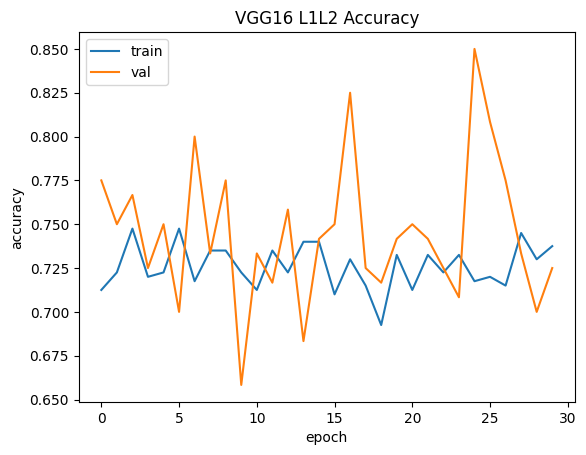

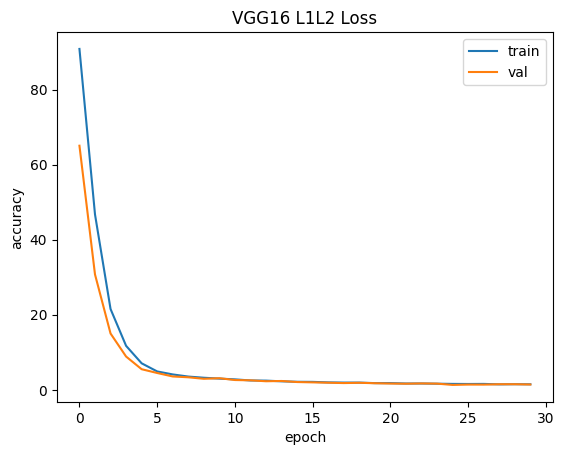

In [33]:
show_accuracy(history_VGGL1L2, 'VGG16', 'L1L2')
show_loss(history_VGGL1L2, 'VGG16', 'L1L2')

In [34]:
loaded_vgg16drop = load_model('VGG16_Dropout.h5')

VGG16_dropout_loss, VGG16_dropout_accuracy = loaded_vgg16drop.evaluate(train_generator)
print("VGG16 train dropout loss : ", VGG16_dropout_loss)
print("VGG16 train dropout accuracy : ", VGG16_dropout_accuracy)

50/50 [==============================] - 27s 521ms/step - loss: 0.8606 - accuracy: 0.7300
VGG16 train dropout loss :  0.8606112003326416
VGG16 train dropout accuracy :  0.7300000190734863


In [35]:
VGG16_dropout_loss, VGG16_dropout_accuracy = loaded_vgg16drop.evaluate(test_generator)
print("VGG16 test dropout loss : ", VGG16_dropout_loss)
print("VGG16 test dropout accuracy : ", VGG16_dropout_accuracy)

50/50 [==============================] - 31s 620ms/step - loss: 0.9075 - accuracy: 0.7225
VGG16 test dropout loss :  0.9074834585189819
VGG16 test dropout accuracy :  0.7225000262260437


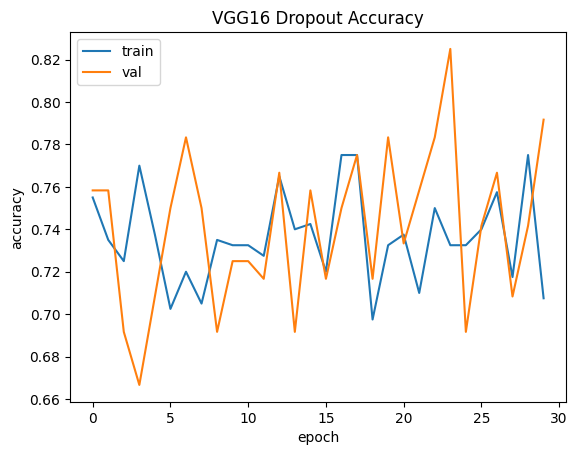

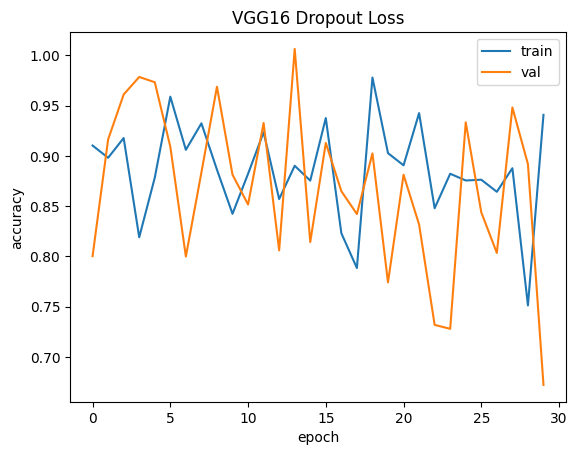

In [36]:
show_accuracy(history_VGGDropout, 'VGG16', 'Dropout')
show_loss(history_VGGDropout, 'VGG16', 'Dropout')

In [10]:
loaded_vgg16earstop = load_model("VGG16_EarlyStopping.h5")

VGG16_earstop_loss, VGG16_earstop_accuracy = loaded_vgg16earstop.evaluate(train_generator)
print("VGG16 train early stopping loss : ", VGG16_earstop_loss)
print("VGG16 train early stopping accuracy : ", VGG16_earstop_accuracy)

50/50 [==============================] - 29s 572ms/step - loss: 0.8219 - accuracy: 0.7575
VGG16 train early stopping loss :  0.8219119906425476
VGG16 train early stopping accuracy :  0.7574999928474426


In [44]:
VGG16_earstop_loss, VGG16_earstop_accuracy = loaded_vgg16earstop.evaluate(test_generator)
print("VGG16 test early stopping loss : ", VGG16_earstop_loss)
print("VGG16 test early stopping accuracy : ", VGG16_earstop_accuracy)

50/50 [==============================] - 31s 628ms/step - loss: 0.7796 - accuracy: 0.7600
VGG16 test early stopping loss :  0.7796214818954468
VGG16 test early stopping accuracy :  0.7599999904632568


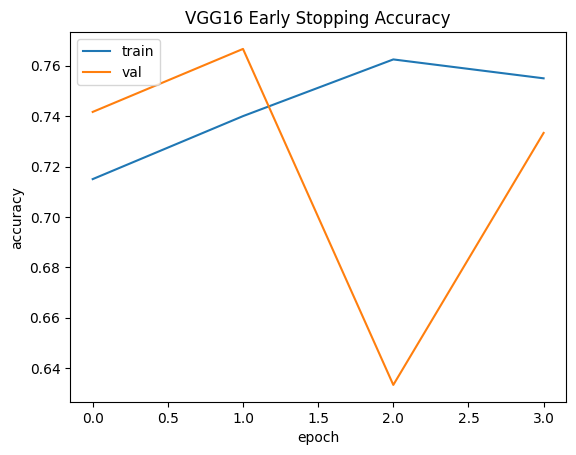

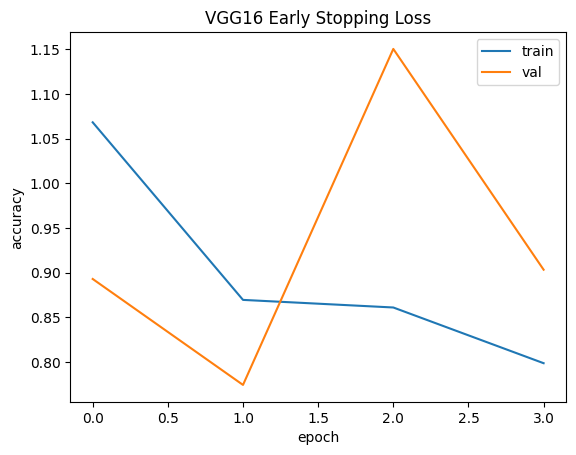

In [45]:
show_accuracy(history_VGGEarlyStopping, 'VGG16', 'Early Stopping')
show_loss(history_VGGEarlyStopping, 'VGG16', 'Early Stopping')

In [46]:
loaded_vgg16aug = load_model("VGG16_Augmentation.h5")

VGG16_aug_loss, VGG16_aug_accuracy = loaded_vgg16aug.evaluate(train_aug_generator)
print("VGG16 train augmentation loss : ", VGG16_aug_loss)
print("VGG16 train augmentation accuracy : ", VGG16_aug_accuracy)

50/50 [==============================] - 44s 891ms/step - loss: 0.9528 - accuracy: 0.6975
VGG16 train augmentation loss :  0.9528003931045532
VGG16 train augmentation accuracy :  0.6974999904632568


In [47]:
VGG16_aug_loss, VGG16_aug_accuracy = loaded_vgg16aug.evaluate(test_generator)
print("VGG16 test augmentation loss : ", VGG16_aug_loss)
print("VGG16 test augmentation accuracy : ", VGG16_aug_accuracy)

50/50 [==============================] - 30s 601ms/step - loss: 0.9242 - accuracy: 0.7200
VGG16 test augmentation loss :  0.9242408275604248
VGG16 test augmentation accuracy :  0.7200000286102295


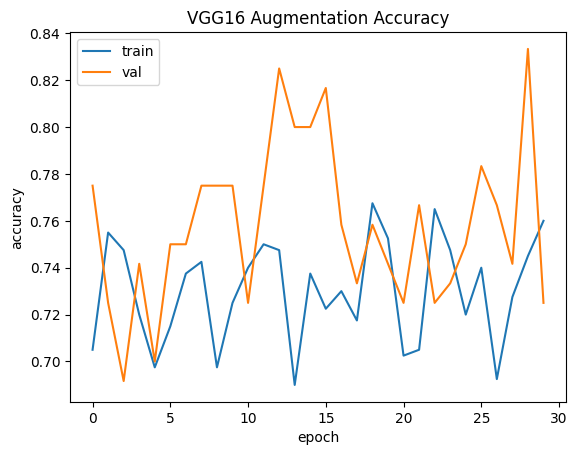

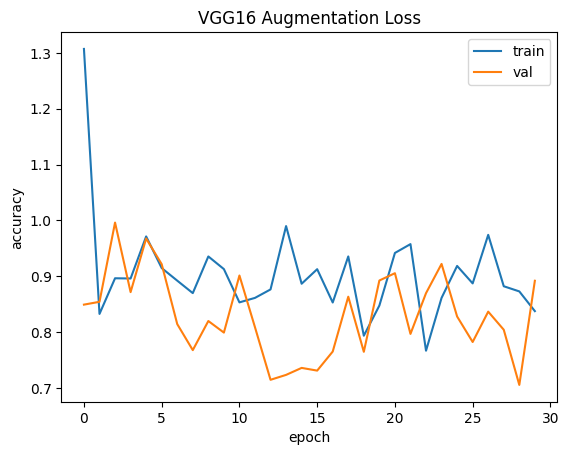

In [48]:
show_accuracy(history_VGGAugmentation, 'VGG16', 'Augmentation')
show_loss(history_VGGAugmentation, 'VGG16', 'Augmentation')

In [49]:
loaded_vgg16batchnorm = load_model("VGG16_BatchNorm.h5")

VGG16_batchnorm_loss, VGG16_batchnorm_accuracy = loaded_vgg16batchnorm.evaluate(train_generator)
print("VGG16 train batch norm loss : ", VGG16_batchnorm_loss)
print("VGG16 train batch norm accuracy : ", VGG16_batchnorm_accuracy)

50/50 [==============================] - 29s 579ms/step - loss: 1.1162 - accuracy: 0.6075
VGG16 train batch norm loss :  1.1162256002426147
VGG16 train batch norm accuracy :  0.6075000166893005


In [50]:
VGG16_batchnorm_loss, VGG16_batchnorm_accuracy = loaded_vgg16batchnorm.evaluate(test_generator)
print("VGG16 test batch norm loss : ", VGG16_batchnorm_loss)
print("VGG16 test batch norm accuracy : ", VGG16_batchnorm_accuracy)

50/50 [==============================] - 30s 597ms/step - loss: 1.0085 - accuracy: 0.6650
VGG16 test batch norm loss :  1.0085378885269165
VGG16 test batch norm accuracy :  0.6650000214576721


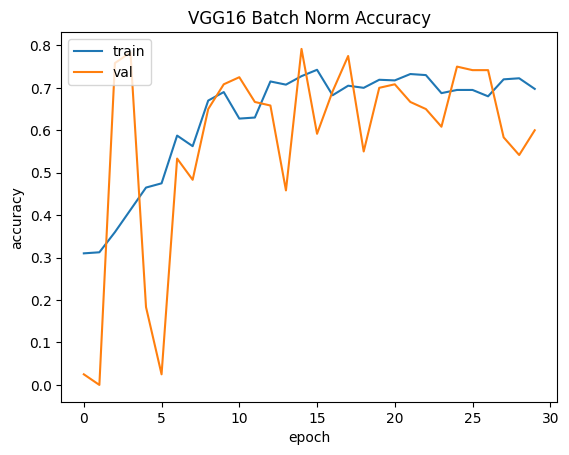

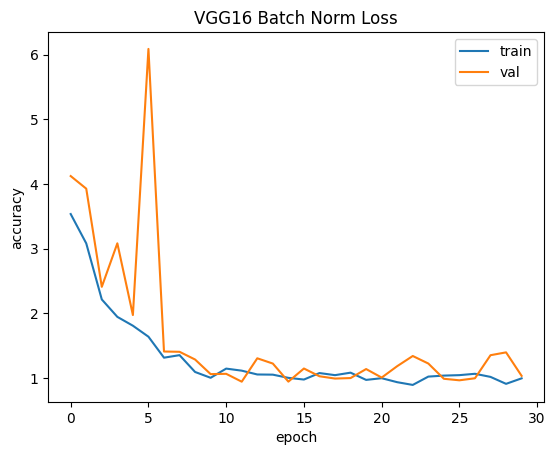

In [51]:
show_accuracy(history_VGGBatchNorm, 'VGG16', 'Batch Norm')
show_loss(history_VGGBatchNorm, 'VGG16', 'Batch Norm')

#### ResNet-50

In [39]:
loaded_rn50 = load_model('ResNet50.h5')

ResNet50_loss, ResNet50_accuracy = loaded_rn50.evaluate(train_generator)
print("ResNet50 train loss : ", ResNet50_loss)
print("ResNet50 train accuracy : ", ResNet50_accuracy)

50/50 [==============================] - 23s 443ms/step - loss: 0.9547 - accuracy: 0.7200
ResNet50 train loss :  0.954684317111969
ResNet50 train accuracy :  0.7200000286102295


In [40]:
ResNet50_loss, ResNet50_accuracy = loaded_rn50.evaluate(test_generator)
print("ResNet50 test loss : ", ResNet50_loss)
print("ResNet50 test accuracy : ", ResNet50_accuracy)

50/50 [==============================] - 28s 570ms/step - loss: 1.1270 - accuracy: 0.6500
ResNet50 test loss :  1.1269888877868652
ResNet50 test accuracy :  0.6499999761581421


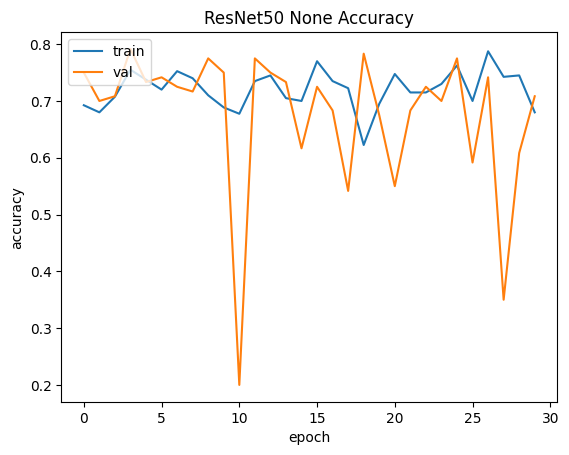

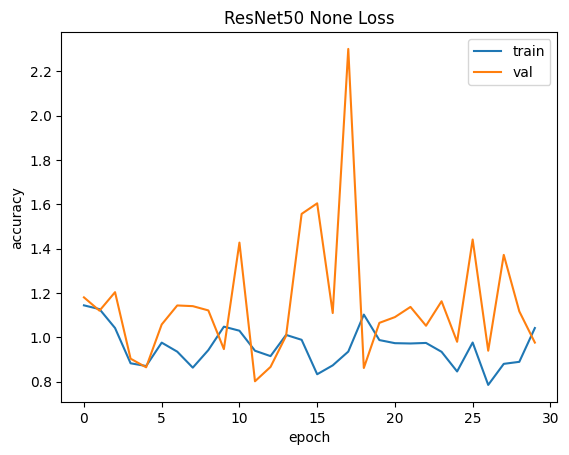

In [41]:
show_accuracy(history_ResNet50, 'ResNet50', 'None')
show_loss(history_ResNet50, 'ResNet50', 'None')

In [42]:
loaded_rn50l1 = load_model('ResNet50_L1.h5')

ResNet50_L1_loss, ResNet50_L1_accuracy = loaded_rn50l1.evaluate(train_generator)
print("ResNet50 train L1 loss : ", ResNet50_L1_loss)
print("ResNet50 train L1 accuracy : ", ResNet50_L1_accuracy)

50/50 [==============================] - 23s 452ms/step - loss: 29.9955 - accuracy: 0.7250
ResNet50 train L1 loss :  29.995450973510742
ResNet50 train L1 accuracy :  0.7250000238418579


In [43]:
ResNet50_L1_loss, ResNet50_L1_accuracy = loaded_rn50l1.evaluate(test_generator)
print("ResNet50 test L1 loss : ", ResNet50_L1_loss)
print("ResNet50 test L1 accuracy : ", ResNet50_L1_accuracy)

50/50 [==============================] - 28s 561ms/step - loss: 30.1271 - accuracy: 0.6625
ResNet50 test L1 loss :  30.127117156982422
ResNet50 test L1 accuracy :  0.6625000238418579


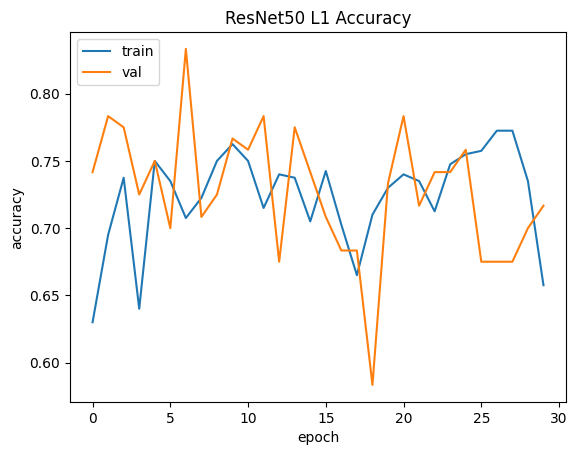

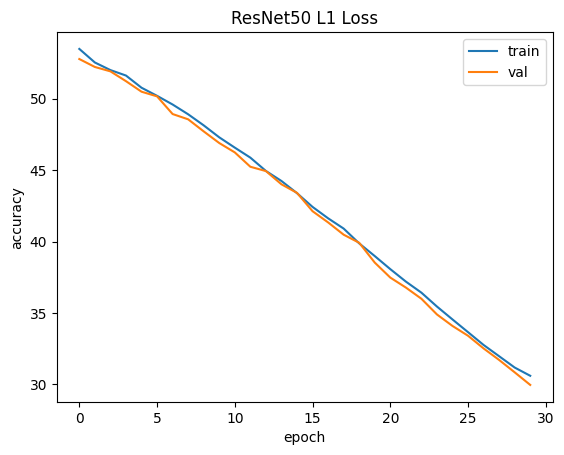

In [44]:
show_accuracy(history_ResNet50L1, 'ResNet50', 'L1')
show_loss(history_ResNet50L1, 'ResNet50', 'L1')

In [45]:
loaded_rn50l2 = load_model('ResNet50_L2.h5')

ResNet50_L2_loss, ResNet50_L2_accuracy = loaded_rn50l2.evaluate(train_generator)
print("ResNet50 train L2 loss : ", ResNet50_L2_loss)
print("ResNet50 train L2 accuracy : ", ResNet50_L2_accuracy)

50/50 [==============================] - 23s 455ms/step - loss: 2.8589 - accuracy: 0.7450
ResNet50 train L2 loss :  2.858879327774048
ResNet50 train L2 accuracy :  0.7450000047683716


In [46]:
ResNet50_L2_loss, ResNet50_L2_accuracy = loaded_rn50l2.evaluate(test_generator)
print("ResNet50 test L2 loss : ", ResNet50_L2_loss)
print("ResNet50 test L2 accuracy : ", ResNet50_L2_accuracy)

50/50 [==============================] - 25s 506ms/step - loss: 2.7959 - accuracy: 0.7675
ResNet50 test L2 loss :  2.7958829402923584
ResNet50 test L2 accuracy :  0.7674999833106995


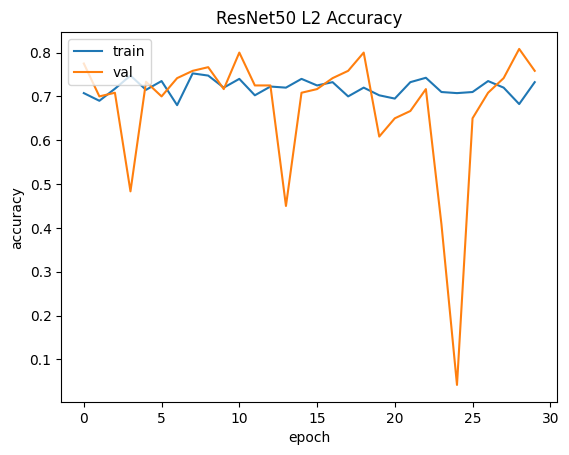

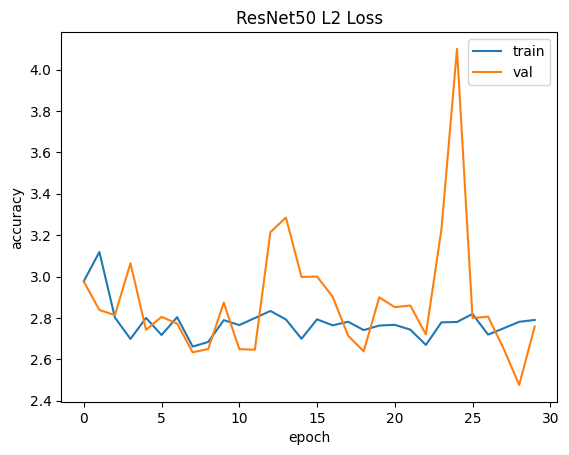

In [47]:
show_accuracy(history_ResNet50L2, 'ResNet50', 'L2')
show_loss(history_ResNet50L2, 'ResNet50', 'L2')

In [48]:
loaded_rn50l1l2 = load_model('ResNet50_L1L2.h5')

ResNet50_L1L2_loss, ResNet50_L1L2_accuracy = loaded_rn50l1l2.evaluate(train_generator)
print("ResNet50 train L1L2 loss : ", ResNet50_L1L2_loss)
print("ResNet50 train L1L2 accuracy : ", ResNet50_L1L2_accuracy)

50/50 [==============================] - 24s 465ms/step - loss: 38.5801 - accuracy: 0.6075
ResNet50 train L1L2 loss :  38.580135345458984
ResNet50 train L1L2 accuracy :  0.6075000166893005


In [49]:
ResNet50_L1L2_loss, ResNet50_L1L2_accuracy = loaded_rn50l1l2.evaluate(test_generator)
print("ResNet50 test L1L2 loss : ", ResNet50_L1L2_loss)
print("ResNet50 test L1L2 accuracy : ", ResNet50_L1L2_accuracy)

50/50 [==============================] - 25s 510ms/step - loss: 38.6590 - accuracy: 0.6075
ResNet50 test L1L2 loss :  38.65896987915039
ResNet50 test L1L2 accuracy :  0.6075000166893005


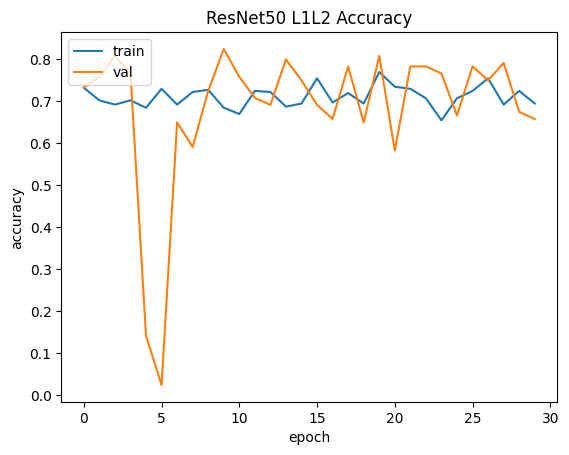

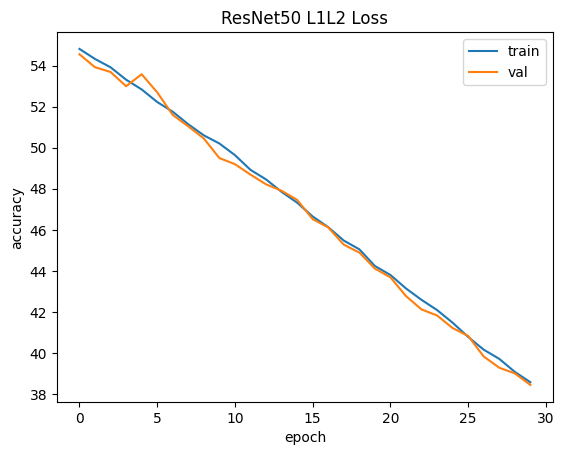

In [50]:
show_accuracy(history_ResNet50L1L2, 'ResNet50', 'L1L2')
show_loss(history_ResNet50L1L2, 'ResNet50', 'L1L2')

In [51]:
loaded_rn50dropout = load_model('ResNet50_Dropout.h5')

ResNet50_dropout_loss, ResNet50_dropout_accuracy = loaded_rn50dropout.evaluate(train_generator)
print("ResNet50 train dropout loss : ", ResNet50_dropout_loss)
print("ResNet50 train dropout accuracy : ", ResNet50_dropout_accuracy)

50/50 [==============================] - 23s 446ms/step - loss: 0.9209 - accuracy: 0.7400
ResNet50 test dropout loss :  0.9209041595458984
ResNet50 test dropout accuracy :  0.7400000095367432


In [52]:
ResNet50_dropout_loss, ResNet50_dropout_accuracy = loaded_rn50dropout.evaluate(test_generator)
print("ResNet50 test dropout loss : ", ResNet50_dropout_loss)
print("ResNet50 test dropout accuracy : ", ResNet50_dropout_accuracy)

50/50 [==============================] - 25s 497ms/step - loss: 1.0677 - accuracy: 0.6925
ResNet50 test dropout loss :  1.0676701068878174
ResNet50 test dropout accuracy :  0.6924999952316284


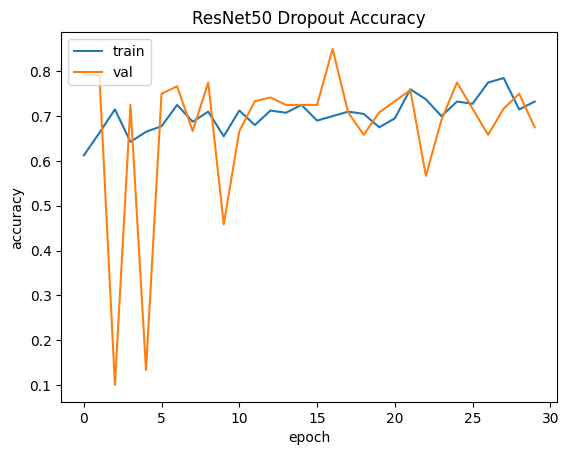

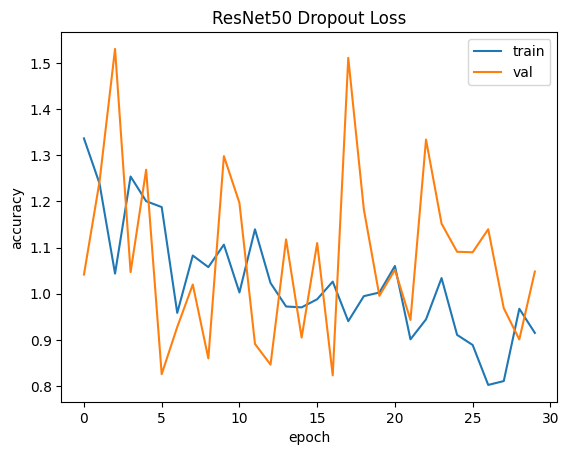

In [53]:
show_accuracy(history_ResNet50Dropout, 'ResNet50', 'Dropout')
show_loss(history_ResNet50Dropout, 'ResNet50', 'Dropout')

In [54]:
loaded_rn50earstop = load_model('ResNet50_EarlyStopping.h5')

ResNet50_earstop_loss, ResNet50_earstop_accuracy = loaded_rn50earstop.evaluate(train_generator)
print("ResNet50 train earstop loss : ", ResNet50_earstop_loss)
print("ResNet50 train earstop accuracy : ", ResNet50_earstop_accuracy)

50/50 [==============================] - 23s 458ms/step - loss: 0.9152 - accuracy: 0.7225
ResNet50 train earstop loss :  0.9151999950408936
ResNet50 train earstop accuracy :  0.7225000262260437


In [55]:
ResNet50_earstop_loss, ResNet50_earstop_accuracy = loaded_rn50earstop.evaluate(test_generator)
print("ResNet50 test earstop loss : ", ResNet50_earstop_loss)
print("ResNet50 test earstop accuracy : ", ResNet50_earstop_accuracy)

50/50 [==============================] - 24s 488ms/step - loss: 0.8528 - accuracy: 0.7525
ResNet50 test earstop loss :  0.8527982234954834
ResNet50 test earstop accuracy :  0.7524999976158142


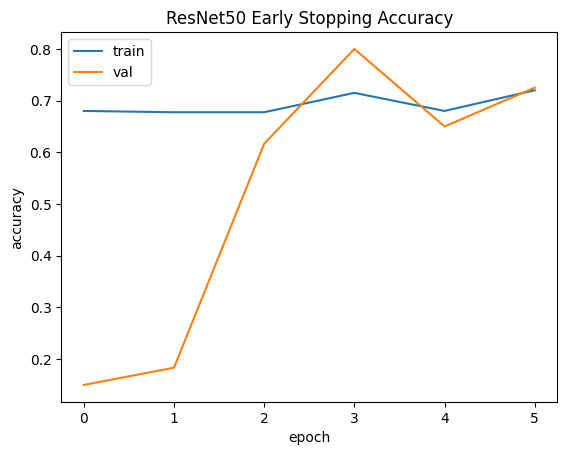

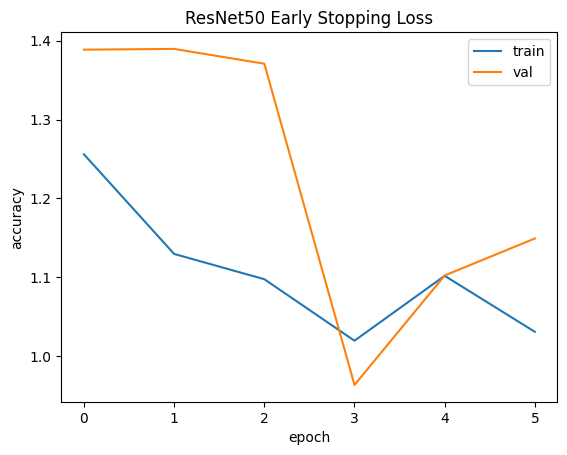

In [23]:
show_accuracy(history_ResNet50EarlyStopping, 'ResNet50', 'Early Stopping')
show_loss(history_ResNet50EarlyStopping, 'ResNet50', 'Early Stopping')

In [56]:
loaded_rn50aug = load_model("ResNet50_Augmentation.h5")

ResNet50_aug_loss, ResNet50_aug_accuracy = loaded_rn50aug.evaluate(train_generator)
print("ResNet50 train augmentation loss : ", ResNet50_aug_loss)
print("ResNet50 train augmentation accuracy : ", ResNet50_aug_accuracy)

50/50 [==============================] - 24s 468ms/step - loss: 0.8448 - accuracy: 0.7550
ResNet50 train augmentation loss :  0.8447619080543518
ResNet50 train augmentation accuracy :  0.7549999952316284


In [57]:
ResNet50_aug_loss, ResNet50_aug_accuracy = loaded_rn50aug.evaluate(test_generator)
print("ResNet50 test augmentation loss : ", ResNet50_aug_loss)
print("ResNet50 test augmentation accuracy : ", ResNet50_aug_accuracy)

50/50 [==============================] - 23s 461ms/step - loss: 0.9323 - accuracy: 0.7425
ResNet50 test augmentation loss :  0.9323016405105591
ResNet50 test augmentation accuracy :  0.7425000071525574


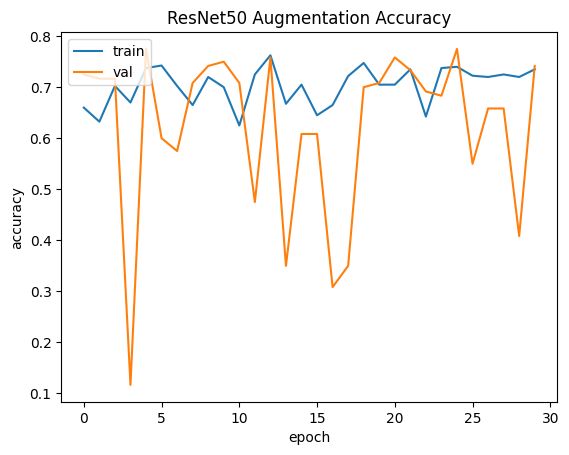

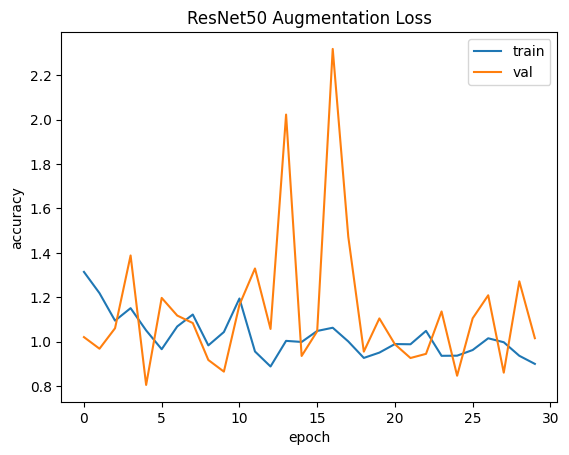

In [58]:
show_accuracy(history_ResNet50Augmentation, "ResNet50", "Augmentation")
show_loss(history_ResNet50Augmentation, "ResNet50", "Augmentation")

In [59]:
loaded_rn50batchnorm = load_model("ResNet50_BatchNorm.h5")

ResNet50_bn_loss, ResNet50_bn_accuracy = loaded_rn50batchnorm.evaluate(train_generator)
print("ResNet50 train batch norm loss : ", ResNet50_bn_loss)
print("ResNet50 train batch norm accuracy : ", ResNet50_bn_accuracy)

50/50 [==============================] - 24s 481ms/step - loss: 1.1808 - accuracy: 0.6575
ResNet50 train batch norm loss :  1.1808457374572754
ResNet50 train batch norm accuracy :  0.6575000286102295


In [60]:
ResNet50_bn_loss, ResNet50_bn_accuracy = loaded_rn50batchnorm.evaluate(test_generator)
print("ResNet50 test batch norm loss : ", ResNet50_bn_loss)
print("ResNet50 test batch norm accuracy : ", ResNet50_bn_accuracy)

50/50 [==============================] - 23s 466ms/step - loss: 1.1078 - accuracy: 0.6875
ResNet50 test batch norm loss :  1.107801079750061
ResNet50 test batch norm accuracy :  0.6875


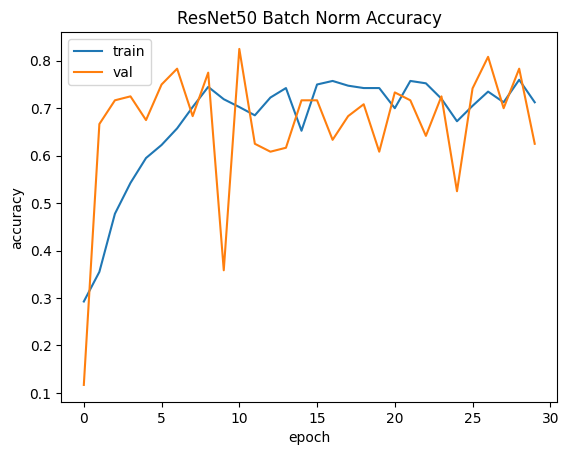

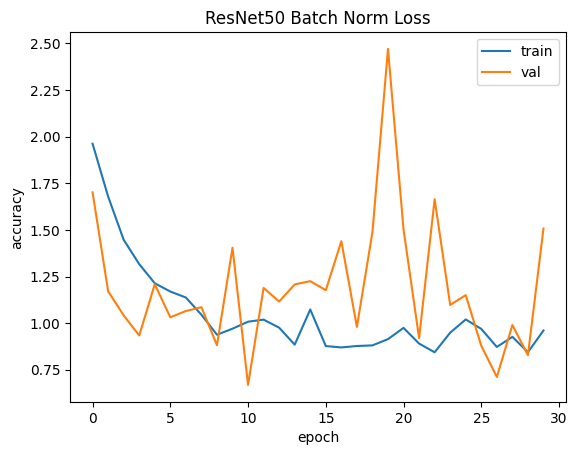

In [61]:
show_accuracy(history_ResNet50BatchNorm, "ResNet50", "Batch Norm")
show_loss(history_ResNet50BatchNorm, "ResNet50", "Batch Norm")

---

### Make Predictions

In [56]:
loaded_vgg16 = load_model('VGG16.h5')
loaded_vgg16l1 = load_model('VGG16_L1.h5')
loaded_vggl2 = load_model('VGG16_L2.h5')
loaded_vgg16l1l2 = load_model('VGG16_L1L2.h5')
loaded_vgg16drop = load_model('VGG16_Dropout.h5')
loaded_vgg16earstop = load_model("VGG16_EarlyStopping.h5")
loaded_vgg16aug = load_model("VGG16_Augmentation.h5")
loaded_vgg16batchnorm = load_model("VGG16_BatchNorm.h5")

loaded_rn50 = load_model('ResNet50.h5')
loaded_rn50l1 = load_model('ResNet50_L1.h5')
loaded_rn50l2 = load_model('ResNet50_L2.h5')
loaded_rn50l1l2 = load_model('ResNet50_L1L2.h5')
loaded_rn50dropout = load_model('ResNet50_Dropout.h5')
loaded_rn50earstop = load_model('ResNet50_EarlyStopping.h5')
loaded_rn50aug = load_model("ResNet50_Augmentation.h5")
loaded_rn50batchnorm = load_model("ResNet50_BatchNorm.h5")

#### VGG16

##### No Regularization

In [7]:
y_pred1 = loaded_vgg16.predict(test_generator)

879/879 [==============================] - 4297s 5s/step


In [8]:
y_pred_class1 = np.argmax(y_pred1, axis=1)
y_true1 = test_generator.classes

cr1 = classification_report(y_true1, y_pred_class1)
print(cr1)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.00      0.00      0.00      1062
           2       0.74      1.00      0.85      5169
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00       166

    accuracy                           0.74      7026
   macro avg       0.15      0.20      0.17      7026
weighted avg       0.54      0.74      0.62      7026



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

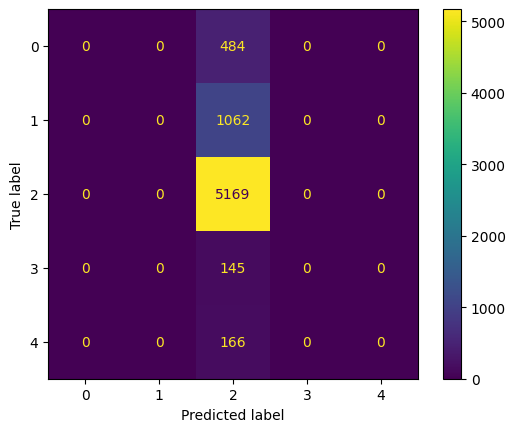

In [9]:
cm1 = confusion_matrix(y_true1, y_pred_class1)
cm_display1 = ConfusionMatrixDisplay(cm1)

cm_display1.plot()
plt.show()

##### L1 

In [10]:
y_pred2 = loaded_vgg16l1.predict(test_generator)

 29/879 [..............................] - ETA: 1:25:05

879/879 [==============================] - 5379s 6s/step


In [11]:
y_pred_class2 = np.argmax(y_pred2, axis=1)
y_true2 = test_generator.classes

cr2 = classification_report(y_true2, y_pred_class2)
print(cr2)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.00      0.00      0.00      1062
           2       0.74      1.00      0.85      5169
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00       166

    accuracy                           0.74      7026
   macro avg       0.15      0.20      0.17      7026
weighted avg       0.54      0.74      0.62      7026



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

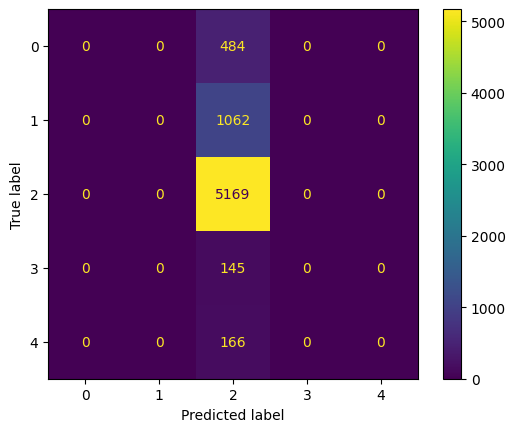

In [12]:
cm2 = confusion_matrix(y_true2, y_pred_class2)
cm_display2 = ConfusionMatrixDisplay(cm2)

cm_display2.plot()
plt.show()

##### L2

In [13]:
y_pred3 = loaded_vggl2.predict(test_generator)

 14/879 [..............................] - ETA: 1:29:21

879/879 [==============================] - 4870s 6s/step


In [14]:
y_pred_class3 = np.argmax(y_pred3, axis=1)
y_true3 = test_generator.classes

cr3 = classification_report(y_true3, y_pred_class3)
print(cr3)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.00      0.00      0.00      1062
           2       0.74      1.00      0.85      5169
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00       166

    accuracy                           0.74      7026
   macro avg       0.15      0.20      0.17      7026
weighted avg       0.54      0.74      0.62      7026



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

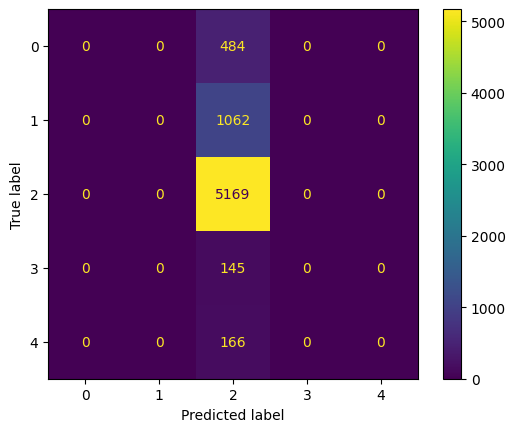

In [15]:
cm3 = confusion_matrix(y_true3, y_pred_class3)
cm_display3 = ConfusionMatrixDisplay(cm3)

cm_display3.plot()
plt.show()

##### Elastic Net

In [16]:
y_pred4 = loaded_vgg16l1l2.predict(test_generator)

103/879 [==>...........................] - ETA: 1:13:10

879/879 [==============================] - 4708s 5s/step


In [17]:
y_pred_class4 = np.argmax(y_pred4, axis=1)
y_true4 = test_generator.classes

cr4 = classification_report(y_true4, y_pred_class4)
print(cr4)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.00      0.00      0.00      1062
           2       0.74      1.00      0.85      5169
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00       166

    accuracy                           0.74      7026
   macro avg       0.15      0.20      0.17      7026
weighted avg       0.54      0.74      0.62      7026



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

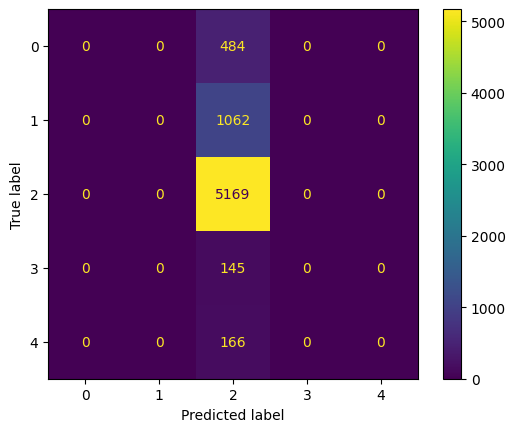

In [18]:
cm4 = confusion_matrix(y_true4, y_pred_class4)
cm_display4 = ConfusionMatrixDisplay(cm4)

cm_display4.plot()
plt.show()

##### Dropout

In [19]:
y_pred5 = loaded_vgg16drop.predict(test_generator)

166/879 [====>.........................] - ETA: 1:17:10

879/879 [==============================] - 5055s 6s/step


In [20]:
y_pred_class5 = np.argmax(y_pred5, axis=1)
y_true5 = test_generator.classes

cr5 = classification_report(y_true5, y_pred_class5)
print(cr5)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.00      0.00      0.00      1062
           2       0.74      1.00      0.85      5169
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00       166

    accuracy                           0.74      7026
   macro avg       0.15      0.20      0.17      7026
weighted avg       0.54      0.74      0.62      7026



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

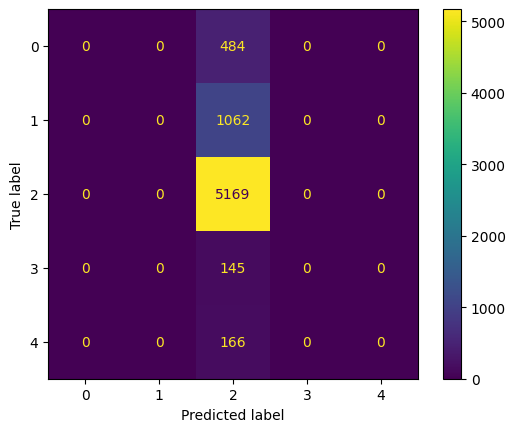

In [21]:
cm5 = confusion_matrix(y_true5, y_pred_class5)
cm_display5 = ConfusionMatrixDisplay(cm5)

cm_display5.plot()
plt.show()

##### Early Stopping

In [22]:
y_pred6 = loaded_vgg16earstop.predict(test_generator)

879/879 [==============================] - 4742s 5s/step


In [23]:
y_pred_class6 = np.argmax(y_pred6, axis=1)
y_true6 = test_generator.classes

cr6 = classification_report(y_true6, y_pred_class6)
print(cr6)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.00      0.00      0.00      1062
           2       0.74      1.00      0.85      5169
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00       166

    accuracy                           0.74      7026
   macro avg       0.15      0.20      0.17      7026
weighted avg       0.54      0.74      0.62      7026



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

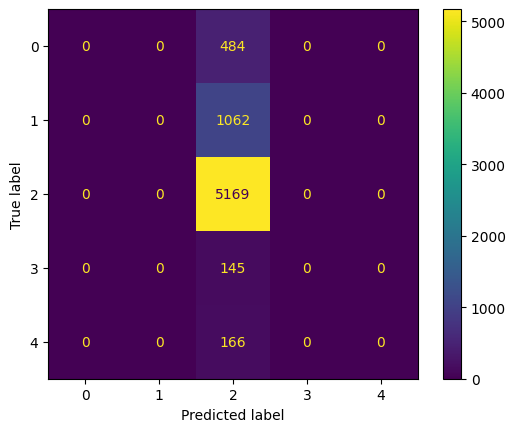

In [24]:
cm6 = confusion_matrix(y_true6, y_pred_class6)
cm_display6 = ConfusionMatrixDisplay(cm6)

cm_display6.plot()
plt.show()

##### Augmentation

In [25]:
y_pred7 = loaded_vgg16aug.predict(test_generator)

224/879 [======>.......................] - ETA: 59:17

879/879 [==============================] - 4808s 5s/step


In [26]:
y_pred_class7 = np.argmax(y_pred7, axis=1)
y_true7 = test_generator.classes

cr7 = classification_report(y_true7, y_pred_class7)
print(cr7)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.00      0.00      0.00      1062
           2       0.74      1.00      0.85      5169
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00       166

    accuracy                           0.74      7026
   macro avg       0.15      0.20      0.17      7026
weighted avg       0.54      0.74      0.62      7026



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

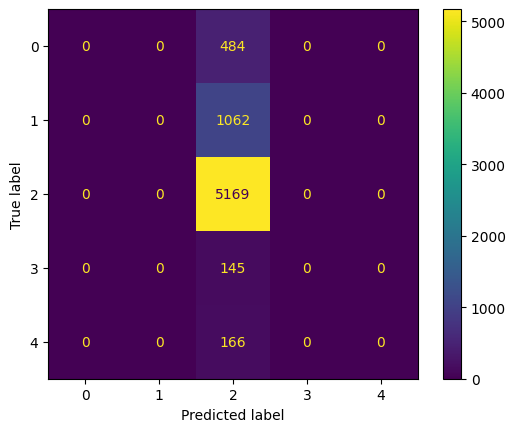

In [27]:
cm7 = confusion_matrix(y_true7, y_pred_class7)
cm_display7 = ConfusionMatrixDisplay(cm7)

cm_display7.plot()
plt.show()

##### Batch Norm

In [28]:
y_pred8 = loaded_vgg16batchnorm.predict(test_generator)

 75/879 [=>............................] - ETA: 1:07:20

879/879 [==============================] - 1442s 2s/step


In [29]:
y_pred_class8 = np.argmax(y_pred8, axis=1)
y_true8 = test_generator.classes

cr8 = classification_report(y_true8, y_pred_class8)
print(cr8)

              precision    recall  f1-score   support

           0       0.06      0.12      0.08       484
           1       0.12      0.03      0.05      1062
           2       0.74      0.83      0.78      5169
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00       166

    accuracy                           0.62      7026
   macro avg       0.18      0.19      0.18      7026
weighted avg       0.56      0.62      0.59      7026



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

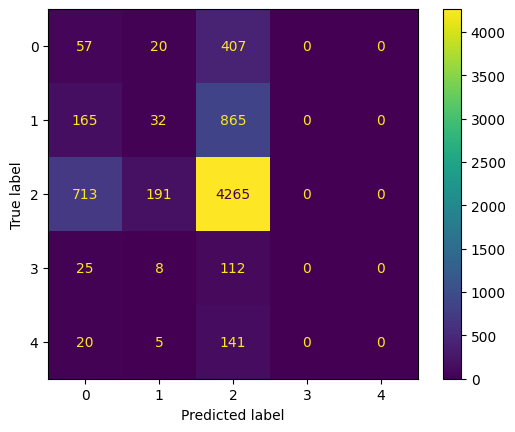

In [30]:
cm8 = confusion_matrix(y_true8, y_pred_class8)
cm_display8 = ConfusionMatrixDisplay(cm8)

cm_display8.plot()
plt.show()

#### ResNet-50

##### No Regularization

In [31]:
y_pred9 = loaded_rn50.predict(test_generator)

879/879 [==============================] - 1043s 1s/step


In [32]:
y_pred_class9 = np.argmax(y_pred9, axis=1)
y_true9 = test_generator.classes

cr9 = classification_report(y_true9, y_pred_class9)
print(cr9)

              precision    recall  f1-score   support

           0       0.07      0.01      0.02       484
           1       0.14      0.04      0.06      1062
           2       0.73      0.94      0.82      5169
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00       166

    accuracy                           0.70      7026
   macro avg       0.19      0.20      0.18      7026
weighted avg       0.56      0.70      0.62      7026



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

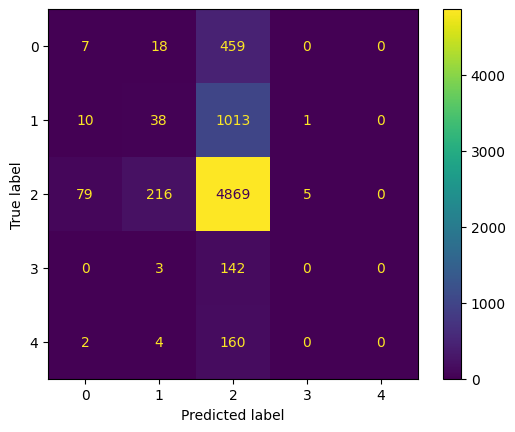

In [33]:
cm9 = confusion_matrix(y_true9, y_pred_class9)
cm_display9 = ConfusionMatrixDisplay(cm9)

cm_display9.plot()
plt.show()

##### L1 

In [34]:
y_pred10 = loaded_rn50l1.predict(test_generator)

879/879 [==============================] - 866s 980ms/step


In [35]:
y_pred_class10 = np.argmax(y_pred10, axis=1)
y_true10 = test_generator.classes

cr10 = classification_report(y_true10, y_pred_class10)
print(cr10)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.13      0.05      0.07      1062
           2       0.73      0.95      0.83      5169
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00       166

    accuracy                           0.70      7026
   macro avg       0.17      0.20      0.18      7026
weighted avg       0.56      0.70      0.62      7026



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

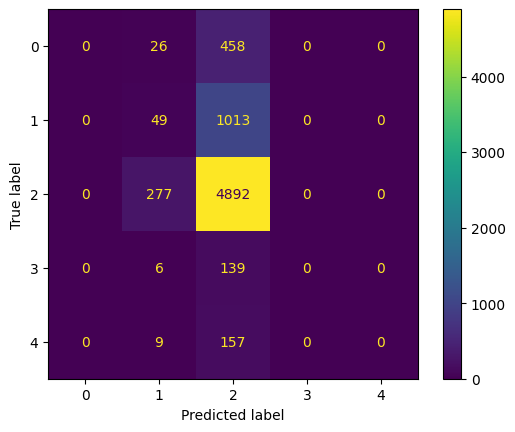

In [36]:
cm10 = confusion_matrix(y_true10, y_pred_class10)
cm_display10 = ConfusionMatrixDisplay(cm10)

cm_display10.plot()
plt.show()

##### L2

In [37]:
y_pred11 = loaded_rn50l2.predict(test_generator)

879/879 [==============================] - 882s 1s/step


In [38]:
y_pred_class11 = np.argmax(y_pred11, axis=1)
y_true11 = test_generator.classes

cr11 = classification_report(y_true11, y_pred_class11)
print(cr11)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.00      0.00      0.00      1062
           2       0.74      1.00      0.85      5169
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00       166

    accuracy                           0.74      7026
   macro avg       0.15      0.20      0.17      7026
weighted avg       0.54      0.74      0.62      7026



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

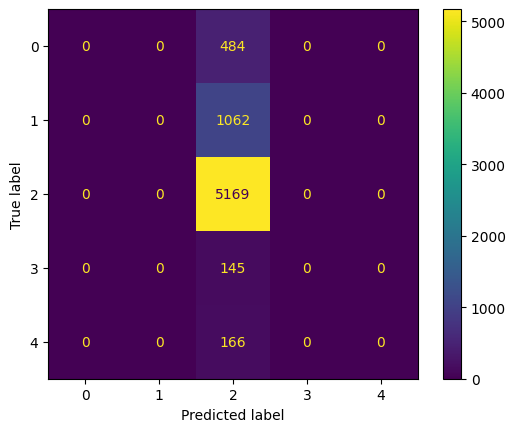

In [39]:
cm11 = confusion_matrix(y_true11, y_pred_class11)
cm_display11 = ConfusionMatrixDisplay(cm11)

cm_display11.plot()
plt.show()

##### Elastic Net

In [40]:
y_pred12 = loaded_rn50l1l2.predict(test_generator)

879/879 [==============================] - 1036s 1s/step


In [41]:
y_pred_class12 = np.argmax(y_pred12, axis=1)
y_true12 = test_generator.classes

cr12 = classification_report(y_true12, y_pred_class12)
print(cr12)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.15      0.11      0.12      1062
           2       0.74      0.83      0.78      5169
           3       0.00      0.00      0.00       145
           4       0.01      0.03      0.02       166

    accuracy                           0.63      7026
   macro avg       0.18      0.19      0.18      7026
weighted avg       0.57      0.63      0.59      7026



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

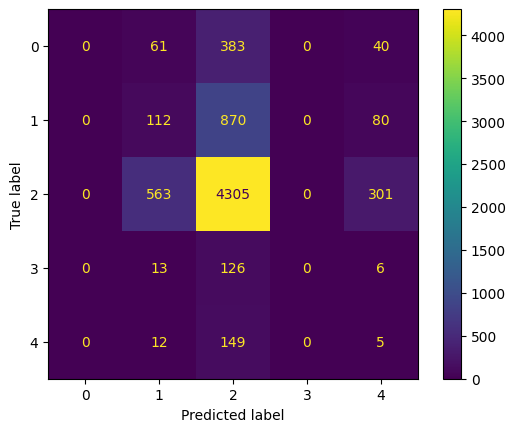

In [42]:
cm12 = confusion_matrix(y_true12, y_pred_class12)
cm_display12 = ConfusionMatrixDisplay(cm12)

cm_display12.plot()
plt.show()

##### Dropout

In [43]:
y_pred13 = loaded_rn50dropout.predict(test_generator)

879/879 [==============================] - 1069s 1s/step


In [44]:
y_pred_class13 = np.argmax(y_pred13, axis=1)
y_true13 = test_generator.classes

cr13 = classification_report(y_true13, y_pred_class13)
print(cr13)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.00      0.00      0.00      1062
           2       0.74      1.00      0.85      5169
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00       166

    accuracy                           0.74      7026
   macro avg       0.15      0.20      0.17      7026
weighted avg       0.54      0.74      0.62      7026



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

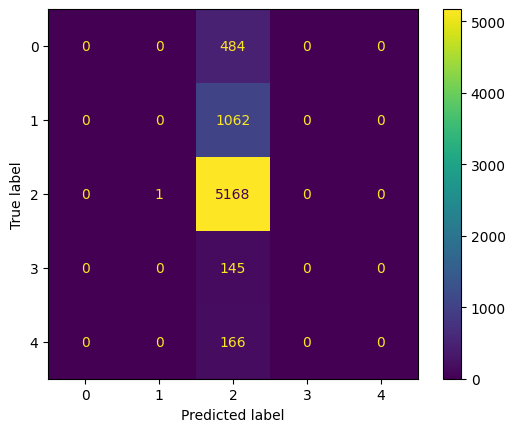

In [45]:
cm13 = confusion_matrix(y_true13, y_pred_class13)
cm_display13 = ConfusionMatrixDisplay(cm13)

cm_display13.plot()
plt.show()

##### Early Stopping

In [46]:
y_pred14 = loaded_rn50earstop.predict(test_generator)

879/879 [==============================] - 1073s 1s/step


In [47]:
y_pred_class14 = np.argmax(y_pred14, axis=1)
y_true14 = test_generator.classes

cr14 = classification_report(y_true14, y_pred_class14)
print(cr14)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.00      0.00      0.00      1062
           2       0.74      1.00      0.85      5169
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00       166

    accuracy                           0.74      7026
   macro avg       0.15      0.20      0.17      7026
weighted avg       0.54      0.74      0.62      7026



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

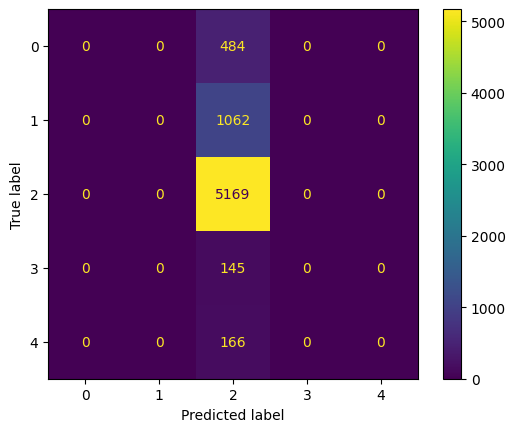

In [48]:
cm14 = confusion_matrix(y_true14, y_pred_class14)
cm_display14 = ConfusionMatrixDisplay(cm14)

cm_display14.plot()
plt.show()

##### Augmentation

In [49]:
y_pred15 = loaded_rn50aug.predict(test_generator)

879/879 [==============================] - 1082s 1s/step


In [50]:
y_pred_class15 = np.argmax(y_pred15, axis=1)
y_true15 = test_generator.classes

cr15 = classification_report(y_true15, y_pred_class15)
print(cr15)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.00      0.00      0.00      1062
           2       0.74      1.00      0.85      5169
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00       166

    accuracy                           0.74      7026
   macro avg       0.15      0.20      0.17      7026
weighted avg       0.54      0.74      0.62      7026



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

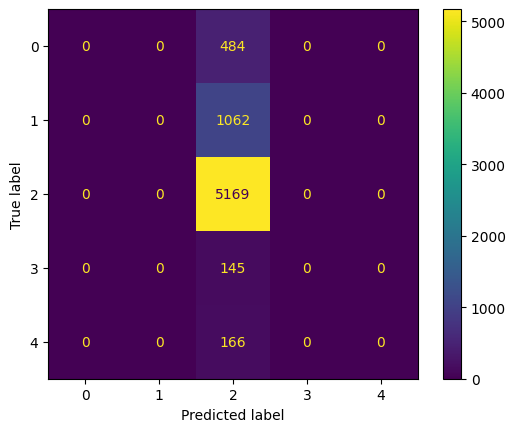

In [51]:
cm15 = confusion_matrix(y_true15, y_pred_class15)
cm_display15 = ConfusionMatrixDisplay(cm15)

cm_display15.plot()
plt.show()

##### Batch Norm

In [52]:
y_pred16 = loaded_rn50batchnorm.predict(test_generator)

879/879 [==============================] - 953s 1s/step


In [53]:
y_pred_class16 = np.argmax(y_pred16, axis=1)
y_true16 = test_generator.classes

cr16 = classification_report(y_true16, y_pred_class16)
print(cr16)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.16      0.12      0.14      1062
           2       0.74      0.89      0.80      5169
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00       166

    accuracy                           0.67      7026
   macro avg       0.18      0.20      0.19      7026
weighted avg       0.57      0.67      0.61      7026



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

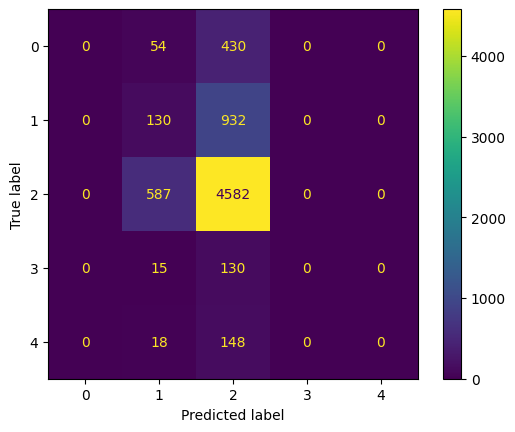

In [54]:
cm16 = confusion_matrix(y_true16, y_pred_class16)
cm_display16 = ConfusionMatrixDisplay(cm16)

cm_display16.plot()
plt.show() 

### Uji Statistik

In [57]:
vgg16 = []
vgg16l1 = []
vgg16l2 = []
vgg16l1l2 = []
vgg16dropout = []
vgg16earstop = []
vgg16aug = []
vgg16batchnorm = []

for i in range (10) :
    vgg16_acc = loaded_vgg16.evaluate(test_generator, steps=50)[1]
    vgg16.append(vgg16_acc)

    vgg16l1_acc = loaded_vgg16l1.evaluate(test_generator, steps=50)[1]
    vgg16l1.append(vgg16l1_acc)

    vgg16l2_acc = loaded_vggl2.evaluate(test_generator, steps=50)[1]
    vgg16l2.append(vgg16l2_acc)

    vgg16l1l2_acc = loaded_vgg16l1l2.evaluate(test_generator, steps=50)[1]
    vgg16l1l2.append(vgg16l1l2_acc)

    vgg16dropout_acc = loaded_vgg16drop.evaluate(test_generator, steps=50)[1]
    vgg16dropout.append(vgg16dropout_acc)

    vgg16earstop_acc = loaded_vgg16earstop.evaluate(test_generator, steps=50)[1]
    vgg16earstop.append(vgg16earstop_acc)

    vgg16aug_acc = loaded_vgg16aug.evaluate(test_generator, steps=50)[1]
    vgg16aug.append(vgg16aug_acc)

    vgg16batchnorm_acc = loaded_vgg16batchnorm.evaluate(test_generator, steps=50)[1]
    vgg16batchnorm.append(vgg16batchnorm_acc)

50/50 [==============================] - 25s 505ms/step - loss: 1.0594 - accuracy: 0.6125


In [58]:
f_stat, p_value = f_oneway(vgg16, 
                           vgg16l1, 
                           vgg16l2, 
                           vgg16l1l2, 
                           vgg16dropout, 
                           vgg16earstop,
                           vgg16aug,
                           vgg16batchnorm)

print("f-statistic : ", f_stat)
print("p-value : ", p_value)

# alpha = 5%
if p_value < 0.05 :
    print("Ada perbedaan akurasi yang signifikan antara model VGG16 tanpa regularisasi dengan model VGG16 dengan penambahan regularisasi")
else:
    print("Tidak ada perbedaan akurasi yang signifikan antara model VGG16 tanpa regularisasi dengan model VGG16 dengan penambahan regularisasi")

f-statistic :  27.492359858399578
p-value :  5.57555427218311e-18
Ada perbedaan akurasi yang signifikan antara model VGG16 tanpa regularisasi dengan model VGG16 dengan penambahan regularisasi


In [59]:
rn50 = []
rn50l1 = []
rn50l2 = []
rn50l1l2 = []
rn50dropout = []
rn50earstop = []
rn50aug = []
rn50batchnorm = []

for i in range (10) :
    rn50_acc = loaded_rn50.evaluate(test_generator, steps=50)[1]
    rn50.append(rn50_acc)

    rn50l1_acc = loaded_rn50l1.evaluate(test_generator, steps=50)[1]
    rn50l1.append(rn50l1_acc)

    rn50l2_acc = loaded_rn50l2.evaluate(test_generator, steps=50)[1]
    rn50l2.append(rn50l2_acc)

    rn50l1l2_acc = loaded_rn50l1l2.evaluate(test_generator, steps=50)[1]
    rn50l1l2.append(rn50l1l2_acc)

    rn50dropout_acc = loaded_rn50dropout.evaluate(test_generator, steps=50)[1]
    rn50dropout.append(rn50dropout_acc)

    rn50earstop_acc = loaded_rn50earstop.evaluate(test_generator, steps=50)[1]
    rn50earstop.append(rn50earstop_acc)

    rn50aug_acc = loaded_rn50aug.evaluate(test_generator, steps=50)[1]
    rn50aug.append(rn50aug_acc)

    rn50batchnorm_acc = loaded_rn50batchnorm.evaluate(test_generator, steps=50)[1]
    rn50batchnorm.append(rn50batchnorm_acc)

50/50 [==============================] - 18s 358ms/step - loss: 1.1329 - accuracy: 0.6850


In [60]:
f_stat2, p_value2 = f_oneway(rn50, 
                           rn50l1, 
                           rn50l2, 
                           rn50l1l2, 
                           rn50dropout, 
                           rn50earstop,
                           rn50aug,
                           rn50batchnorm)

print("f-statistic : ", f_stat2)
print("p-value : ", p_value2)

# alpha = 5%
if p_value2 < 0.05 :
    print("Ada perbedaan akurasi yang signifikan antara model ResNet-50 tanpa regularisasi dengan model ResNet-50 dengan penambahan regularisasi")
else:
    print("Tidak ada perbedaan akurasi yang signifikan antara model ResNet-50 tanpa regularisasi dengan model ResNet-50 dengan penambahan regularisasi")

f-statistic :  31.63538821283095
p-value :  1.436553606386926e-19
Ada perbedaan akurasi yang signifikan antara model ResNet-50 tanpa regularisasi dengan model ResNet-50 dengan penambahan regularisasi


In [3]:
import numpy as np
a = np.arange(6).reshape(2,3) + 10
a


array([[10, 11, 12],
       [13, 14, 15]])

In [4]:
np.argmax(a, axis=0)

array([1, 1, 1], dtype=int64)

In [5]:
np.argmax(a, axis=1)

array([2, 2], dtype=int64)

In [ ]:
test = []
np.argmax(a, out=test)
test